# Library import

In [ ]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import random
from tqdm import tqdm
from yellowbrick.model_selection import learning_curve

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load the data file

In [ ]:
#Change path according to your drive location!
INPUT_MAESTRO_DATA = "/content/drive/MyDrive/ProteoSAFe-MAESTRO-d6178bdd-identified_variants_merged_protein_regions/MAESTRO-d6178bdd-identified_variants_merged_protein_regions-main.tsv"
variants = pd.read_csv(INPUT_MAESTRO_DATA, sep="\t", low_memory=False)

In [ ]:
variants

rowid  ccms_row_id   Algorithm      Filename  Cluster_index  \
0            1            1      .MODA.  specs_ms.mgf         960991   
1            2            2      .MODA.  specs_ms.mgf         763982   
2            3            3  .MSGFPLUS.  specs_ms.mgf         902201   
3            4            4  .MSGFPLUS.  specs_ms.mgf         935503   
4            5            5      .MODA.  specs_ms.mgf         297961   
...        ...          ...         ...           ...            ...   
101456  101457       101457      .MODA.  specs_ms.mgf         480358   
101457  101458       101458      .MODA.  specs_ms.mgf         237950   
101458  101459       101459      .MODA.  specs_ms.mgf        1037953   
101459  101460       101460      .MODA.  specs_ms.mgf        1022758   
101460  101461       101461      .MODA.  specs_ms.mgf        1021872   

                                               Peptide  \
0        K.[304.207]GARLIPEMDQIFTEVEMTTLE(K,304.207).V   
1                   I.[304.207]FTEVEMTTLE(K,304.207).V   
2                         K.[304.207]LYQPEYQEVSTEEQR.E   
3               K.[304.207]AANSLEAFIFETQD(K,304.207).L   
4                      R.[304.207]YSHDF(N,-56.985)FH.I   
...                                                ...   
101456       K.[304.207]YLGE(E,-68.078)YV(K,304.207).A   
101457        K.[304.207]YL(G,55.921)EEYV(K,304.207).A   
101458        K.{187.018}[304.207]YLGEEYV(K,304.207).A   
101459  R.[304.207]NTYE(K,361.237)YLGEEYV(K,304.207).A   
101460       K.[304.207]YLGE(E,125.898)YV(K,304.207).A   

             Unmodified_sequence  Charge  _dyn_#Intensity_for_cluster  \
0       .GARLIPEMDQIFTEVEMTTLEK.       4                    36.905893   
1                  .FTEVEMTTLEK.       3                    11.686782   
2              .LYQPEYQEVSTEEQR.       3                    15.690234   
3              .AANSLEAFIFETQDK.       3                    15.016824   
4                     .YSHDFNFH.       3                    33.768015   
...                          ...     ...                          ...   
101456                .YLGEEYVK.       3                    15.671927   
101457                .YLGEEYVK.       4                    13.932377   
101458                .YLGEEYVK.       2                    14.412538   
101459           .NTYEKYLGEEYVK.       3                    13.872686   
101460                .YLGEEYVK.       2                    14.889704   

        _dyn_#Intensity_for_unmodified_sequence  ...  PSP_site_match  \
0                                     36.905893  ...             NaN   
1                                     11.686782  ...             NaN   
2                                     15.690234  ...             NaN   
3                                     15.016824  ...             NaN   
4                                     33.768015  ...             NaN   
...                                         ...  ...             ...   
101456                                14.867811  ...             NaN   
101457                                14.867811  ...             NaN   
101458                                14.867811  ...             NaN   
101459                                22.237222  ...             NaN   
101460                                14.867811  ...             NaN   

                                           DrugBank_drugs  Parent_mass  \
0                                                     NaN      1580.81   
1                                                     NaN      1934.91   
2                                                     NaN      2203.09   
3                                                     NaN      2292.24   
4                                                     NaN      1313.66   
...                                                   ...          ...   
101456  |Cisplatin|Isoflurophate|Iron Dextran|Bismuth ...      1027.56   
101457  |Cisplatin|Isoflurophate|Iron Dextran|Bismuth ...      1664.83   
101458  |Cisplatin|Isoflurophate|Iron D

In [ ]:
print("The number of column =", len(variants.columns))
for c in variants.columns:
    print(c)

The number of column = 268
rowid
ccms_row_id
Algorithm
Filename
Cluster_index
Peptide
Unmodified_sequence
Charge
_dyn_#Intensity_for_cluster
_dyn_#Intensity_for_unmodified_sequence
Num_G1_spectra_for_unmodified_sequence
Num_G2_spectra_for_unmodified_sequence
Num_G3_spectra_for_unmodified_sequence
Num_G4_spectra_for_unmodified_sequence
Num_G5_spectra_for_unmodified_sequence
Num_G6_spectra_for_unmodified_sequence
_dyn_#Empty.Empty.Empty..Empty.1_intensity_for_unmodified_sequence
_dyn_#Healthy.HC1.Healthy..HC1.1_intensity_for_unmodified_sequence
_dyn_#Healthy.HC10.Healthy..HC10.1_intensity_for_unmodified_sequence
_dyn_#Healthy.HC12.Healthy..HC12.1_intensity_for_unmodified_sequence
_dyn_#Healthy.HC13.Healthy..HC13.1_intensity_for_unmodified_sequence
_dyn_#Healthy.HC17.Healthy..HC17.1_intensity_for_unmodified_sequence
_dyn_#Healthy.HC19.Healthy..HC19.1_intensity_for_unmodified_sequence
_dyn_#Healthy.HC2.Healthy..HC2.1_intensity_for_unmodified_sequence
_dyn_#Healthy.HC20.Healthy..HC20.1_inte

# Preprocessing

In [ ]:
def len_df(df, col_name, val):
  """
  Return number of rows with col_name column's value == val
  """
  return len(df[df[col_name] == val])

In [ ]:
# we only need the intensities for each peptide, noted as "...intensity_for_peptide_variant"
variants_processed = variants[
    ['Peptide'] + [c for c in variants.columns if 'intensity_for_peptide_variant' in c]
]

#set the index to be each Peptide
variants_processed = variants_processed.set_index('Peptide')

#transpose the matrix, so each column is a peptide
variants_processed = variants_processed.T

#only retain first two elements in the headers
variants_processed.index = variants_processed.index.map(lambda x: '.'.join(x.split('.')[:2]))

#set the condition to the first element
variants_processed['Condition'] = variants_processed.index.map(lambda x: x.split('.')[0])

print(variants_processed['Condition'].unique())
print(len_df(variants_processed, 'Condition', '_dyn_#Non-severe-COVID-19'))

variants_processed['Original Class'] = variants_processed['Condition']
variants_processed['Original Class'].replace({"_dyn_#Severe-COVID-19":"Severe-COVID-19", "_dyn_#Non-severe-COVID-19":"Non-severe-COVID-19",
                                         "_dyn_#Healthy":"Healthy", "_dyn_#Symptomatic-non-COVID-19":"Symptomatic-non-COVID-19"},
                                        inplace=True)

variants_processed['Condition'].replace({"_dyn_#Severe-COVID-19":"Covid", "_dyn_#Non-severe-COVID-19":"Covid",
                                         "_dyn_#Healthy":"No-Covid", "_dyn_#Symptomatic-non-COVID-19":"No-Covid"},
                                        inplace=True)

#only keep two conditions, for both severe and non-severe COVID-19
variants_processed = variants_processed[(variants_processed.Condition == "Covid") 
                             | (variants_processed.Condition == "No-Covid")]

#variants_processed  # print out to investigate

['_dyn_#Empty' '_dyn_#Healthy' '_dyn_#Non-severe-COVID-19' '_dyn_#Norm'
 '_dyn_#Severe-COVID-19' '_dyn_#Symptomatic-non-COVID-19']
25


In [ ]:
variants_processed.groupby('Original Class').size()

Original Class
Healthy                     22
Non-severe-COVID-19         25
Severe-COVID-19             18
Symptomatic-non-COVID-19    25
dtype: int64

In [ ]:
variants_processed.groupby('Condition').size()

Condition
Covid       43
No-Covid    47
dtype: int64

In [ ]:
variants_processed.head()

Peptide             K.[304.207]GARLIPEMDQIFTEVEMTTLE(K,304.207).V  \
_dyn_#Healthy.HC1                                        0.000000   
_dyn_#Healthy.HC10                                       6.645649   
_dyn_#Healthy.HC12                                       3.391896   
_dyn_#Healthy.HC13                                       1.919552   
_dyn_#Healthy.HC17                                       0.000000   

Peptide             I.[304.207]FTEVEMTTLE(K,304.207).V  \
_dyn_#Healthy.HC1                                  0.0   
_dyn_#Healthy.HC10                                 0.0   
_dyn_#Healthy.HC12                                 0.0   
_dyn_#Healthy.HC13                                 0.0   
_dyn_#Healthy.HC17                                 0.0   

Peptide             K.[304.207]LYQPEYQEVSTEEQR.E  \
_dyn_#Healthy.HC1                       0.935916   
_dyn_#Healthy.HC10                      0.000000   
_dyn_#Healthy.HC12                      0.000000   
_dyn_#Healthy.HC13                      0.000000   
_dyn_#Healthy.HC17                      0.286530   

Peptide             K.[304.207]AANSLEAFIFETQD(K,304.207).L  \
_dyn_#Healthy.HC1                                 0.000000   
_dyn_#Healthy.HC10                                0.000000   
_dyn_#Healthy.HC12                                0.000000   
_dyn_#Healthy.HC13                                0.000000   
_dyn_#Healthy.HC17                                1.259306   

Peptide             R.[304.207]YSHDF(N,-56.985)FH.I  \
_dyn_#Healthy.HC1                               0.0   
_dyn_#Healthy.HC10                              0.0   
_dyn_#Healthy.HC12                              0.0   
_dyn_#Healthy.HC13                              0.0   
_dyn_#Healthy.HC17                              0.0   

Peptide             R.[304.207](P,143.096)SV(C,57.021)REAGPQAHMQQVTSSL(K,304.207).G  \
_dyn_#Healthy.HC1                                                 0.0                 
_dyn_#Healthy.HC10                                                0.0                 
_dyn_#Healthy.HC12                                                0.0                 
_dyn_#Healthy.HC13                                                0.0                 
_dyn_#Healthy.HC17                                                0.0                 

Peptide             K.[304.207]QGSTGEEFHFQTGGR.D  \
_dyn_#Healthy.HC1                            0.0   
_dyn_#Healthy.HC10                           0.0   
_dyn_#Healthy.HC12                           0.0   
_dyn_#Healthy.HC13                           0.0   
_dyn_#Healthy.HC17                           0.0   

Peptide             K.[304.207]HGTDDGVVW(M,15.995)NW(K,304.207).G  \
_dyn_#Healthy.HC1                                             0.0   
_dyn_#Healthy.HC10                                            0.0   
_dyn_#Healthy.HC12                                            0.0   
_dyn_#Healthy.HC13                                            0.0   
_dyn_#Healthy.HC17                                            0.0   

Peptide             K.[304.207](H,100.027)GTDDGVVWMNW(K,304.207).G  \
_dyn_#Healthy.HC1                                              0.0   
_dyn_#Healthy.HC10                                             0.0   
_dyn_#Healthy.HC12                                             0.0   
_dyn_#Healthy.HC13                                             0.0   
_dyn_#Healthy.HC17                                             0.0   

Peptide             K.[304.207]H(G,304.213)TDDGVVWMNW(K,304.207).G  ...  \
_dyn_#Healthy.HC1                                         0.288821  ...   
_dyn_#Healthy.HC10                                        0.026024  ...   
_dyn_#Healthy.HC12                                        0.009033  ...   
_dyn_#Healthy.HC13                                        0.028415  ...   
_dyn_#Healthy.HC17                                        0.000000  ...   

Peptide             K.[304.207]YLGEE(Y,-58.064)V(K,304.207).A  \
_dyn_#Healthy.HC1              

In [ ]:
def z_score(df):
    # copy the dataframe
    df_std = df.copy()
    # apply the z-score method
    for column in df_std.columns:
        df_std[column] = (df_std[column] - df_std[column].mean()) / df_std[column].std()
        df_std[column] = df_std[column].map(lambda x: x if np.isnan(x) else min(3,max(-3,x)))
    return df_std, df.mean(), df.std()

In [ ]:
def log_scaling(df):
  from sklearn.preprocessing import PowerTransformer
  pt = PowerTransformer()
  df_std = df.copy()
  transformer = pt.fit(df_std)
  df_std = pd.DataFrame(pt.fit_transform(df_std), columns=df_std.columns)
  return df_std, transformer

In [ ]:
def replace_zeros_with_NAs(df):
  return df.replace(0.0, np.nan)

In [ ]:
def replace_nan_with_zeroes(df):
  return df.replace(np.nan, 0.0)

In [ ]:
def drop_samples_with_nas(df):
  return df.dropna(axis = 0) #drop rows

In [ ]:
def drop_peptide_with_nas(df):
  '''
  Drop the peptides with top 10% maximum NAs
  '''
  num_samples = df.shape[0]
  #Analyzing number of nans in each column
  series = df.isna().sum().sort_values(ascending=False) #Sort peptides with max number of NAs
  top_ten_percent_peptides = int(df.shape[1] * 0.1) #Top 10% of samples with most NAs
  number_of_nas = series.iloc[:top_ten_percent_peptides].mean() #Use mean of top 10%
  return df.dropna(axis=1, thresh=(num_samples-number_of_nas)) #drop columns with "thresh" non-nan samples

In [ ]:
def drop_all_peptide_with_nas(df):
  '''
  Drop all the peptides with NAs
  '''
  return df.dropna(axis = 1) #drop columns

In [ ]:
def impute_values_mean(df):
  return df.fillna(df.mean()), df.mean()

In [ ]:
def impute_values_median(df):
  return df.fillna(df.median()), df.median()

In [ ]:
all_peptides_removed = replace_zeros_with_NAs(variants_processed)
print("Shape Before: " , all_peptides_removed.shape)
all_peptides_removed = drop_all_peptide_with_nas(all_peptides_removed)
print("Shape After: " ,all_peptides_removed.shape)

Shape Before:  (90, 101463)
Shape After:  (90, 10636)


In [ ]:
#Convert missing values to NA
variants_dropped_ten_percent = replace_zeros_with_NAs(variants_processed)
#Drop peptides with too many NAs
print("Shape Before: " , variants_dropped_ten_percent.shape)
variants_dropped_ten_percent = drop_peptide_with_nas(variants_dropped_ten_percent)
#variants_processed = replace_nan_with_zeroes(variants_processed)
print("Shape After: " ,variants_dropped_ten_percent.shape)

Shape Before:  (90, 101463)
Shape After:  (90, 100189)


# Feature Selection if we want


In [ ]:
peptide_features = list(variants_processed.columns)
for peptide_1 in peptide_features:
  for peptide_2 in peptide_features:
    if(peptide_1 != peptide_2 and peptide_1!="Condition" and peptide_2!="Condition" and peptide_1!="Original Class" and peptide_2!="Original Class"):
      #print(peptide_1, peptide_2)
      cor = variants_processed[peptide_1].corr(variants_processed[peptide_2])

      if(cor > 0.5):
        peptide_features.remove(peptide_2)


In [ ]:
final_features_data = variants_processed[peptide_features]

In [ ]:
final_features_data.shape

(90, 831)

# Split Train/Test

In [ ]:
def split_train_test(df):

  #Group samples from all 4 classes 
  severe = len_df(df, 'Original Class', 'Severe-COVID-19')
  non_severe = len_df(df, 'Original Class', 'Non-severe-COVID-19')
  healthy = len_df(df, 'Original Class', 'Healthy')
  symp_non_covid = len_df(df, 'Original Class', 'Symptomatic-non-COVID-19')

  severe_df = df[df['Original Class'] == 'Severe-COVID-19']
  non_severe_df = df[df['Original Class'] == 'Non-severe-COVID-19']
  healthy_df = df[df['Original Class'] == 'Healthy']
  symp_non_covid_df = df[df['Original Class'] == 'Symptomatic-non-COVID-19']

  #Split all 4 classes into train and test
  from sklearn.model_selection import train_test_split

  X_train_severe, X_test_severe, y_train_severe, y_test_severe = train_test_split(severe_df, severe_df['Condition'], test_size=0.3, random_state=1)

  X_train_non_severe, X_test_non_severe, y_train_non_severe, y_test_non_severe = train_test_split(non_severe_df, non_severe_df['Condition'], test_size=0.2, random_state=1)

  X_train_healthy, X_test_healthy, y_train_healthy, y_test_healthy = train_test_split(healthy_df, healthy_df['Condition'], test_size=0.3, random_state=1)

  X_train_symp_non_covid, X_test_symp_non_covid, y_train_symp_non_covid, y_test_symp_non_covid = train_test_split(symp_non_covid_df, symp_non_covid_df['Condition'], test_size=0.2, random_state=1)

  #Combine 4 classes into train and test
  X_train = pd.concat([X_train_severe, X_train_non_severe, X_train_healthy, X_train_symp_non_covid]).drop('Condition', 1).drop('Original Class', 1)
  X_test = pd.concat([X_test_severe, X_test_non_severe, X_test_healthy, X_test_symp_non_covid]).drop('Condition', 1).drop('Original Class', 1)

  y_train = pd.concat([y_train_severe, y_train_non_severe, y_train_healthy, y_train_symp_non_covid])
  y_test = pd.concat([y_test_severe, y_test_non_severe, y_test_healthy, y_test_symp_non_covid])

  #Combine 4 classes into train and test
  X_train = pd.concat([X_train_severe, X_train_non_severe, X_train_healthy, X_train_symp_non_covid]).drop('Condition', 1).drop('Original Class', 1)
  X_test = pd.concat([X_test_severe, X_test_non_severe, X_test_healthy, X_test_symp_non_covid]).drop('Condition', 1).drop('Original Class', 1)

  y_train = pd.concat([y_train_severe, y_train_non_severe, y_train_healthy, y_train_symp_non_covid])
  y_test = pd.concat([y_test_severe, y_test_non_severe, y_test_healthy, y_test_symp_non_covid])

  print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

  #Perform shuffling!
  from sklearn.utils import shuffle
  X_train, y_train = shuffle(X_train, y_train)
  X_test, y_test = shuffle(X_test, y_test)


  #Transform class labels to 0 and 1
  y_train.replace({"Covid":1, "No-Covid":0},inplace=True)
  y_test.replace({"Covid":1, "No-Covid":0},inplace=True)

  return X_train, y_train, X_test, y_test



In [ ]:
# For all peptides removed model
X_train, y_train, X_test, y_test = split_train_test(final_features_data)

(67, 829) (67,) (23, 829) (23,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


# Preparing data for training

In [ ]:
def prepare_train_data(df_train):
  #------------Baseline Model----------------------------------------------
  baseline_train_data = replace_nan_with_zeroes(X_train)
  #------------Model 1 - Dropping too many NAs, z-score norm---------------
  m_1_processed_data, m_1_mean, m_1_std = z_score(X_train)
  #------------Model 2 - Dropping too many NAs, log-scale norm---------------
  m_2_processed_data, m_2_transformer = log_scaling(X_train.copy())
  #------------Model 3 - Dropping too many NAs, impute mean ---------------
  m_3_processed_data, m_3_mean = impute_values_mean(X_train)
  #------------Model 4 - Dropping too many NAs, impute median---------------
  m_4_processed_data, m_4_median = impute_values_median(X_train)
  #------------Model 5 - Dropping too many NAs, z-scale norm, impute mean---------------
  m_5_processed_data, m_5_mean = impute_values_mean(m_1_processed_data.copy())
  #------------Model 6 - Dropping too many NAs, z-scale norm, impute median---------------
  m_6_processed_data, m_6_median = impute_values_median(m_1_processed_data.copy())
  #------------Model 7 - Dropping too many NAs, log norm, impute mean---------------
  m_7_processed_data, m_7_mean = impute_values_mean(m_2_processed_data.copy())
  #------------Model 8 - Dropping too many NAs, log norm, impute median---------------
  m_8_processed_data, m_8_median = impute_values_median(m_2_processed_data.copy())

  return [baseline_train_data, m_1_processed_data, m_2_processed_data, m_3_processed_data, m_4_processed_data, m_5_processed_data, m_6_processed_data, m_7_processed_data, m_8_processed_data], [m_1_mean, m_1_std, m_2_transformer, m_3_mean, m_4_median, m_5_mean, m_6_median, m_7_mean, m_8_median]

# Prepare data for testing

In [ ]:
#z-score for test - Use mean and std from train
def z_score_test(df, df_train_mean, df_train_std):
    # copy the dataframe
    df_std = df.copy()
    # apply the z-score method
    for column in df_std.columns:
        df_std[column] = (df_std[column] - df_train_mean[column]) / df_train_std[column]
        df_std[column] = df_std[column].map(lambda x: x if np.isnan(x) else min(3,max(-3,x)))
    return df_std

In [ ]:
#log-scaling for test - Use params from train
def log_scaling_test(df, transformer):
  return pd.DataFrame(transformer.transform(df.copy()), columns=df.columns)

In [ ]:
def prepare_testing(df_test, helper_values):
  #[m_1_mean, m_1_std, m_2_transformer, m_3_mean, m_4_median, m_5_mean, m_6_median, m_7_mean, m_8_median]
  #------------Baseline Model----------------------------------------------
  baseline_test_data = replace_nan_with_zeroes(X_test)
  #------------Model 1 - Dropping too many NAs, z-score norm---------------
  m_1_test_data = z_score_test(X_test, helper_values[0], helper_values[1]) #m_1_mean, m_1_std
  #------------Model 2 - Dropping too many NAs, log-scale norm---------------
  m_2_test_data = log_scaling_test(X_test, helper_values[2]) # m_2_transformer
  #------------Model 3 - Dropping too many NAs, impute mean ---------------
  m_3_test_data = X_test.fillna(helper_values[3]) #m_3_mean
  #------------Model 4 - Dropping too many NAs, impute median---------------
  m_4_test_data = X_test.fillna(helper_values[4]) #m_4_median
  #------------Model 5 - Dropping too many NAs, z-scale norm, impute mean---------------
  m_5_test_data = m_1_test_data.copy().fillna(helper_values[5]) #m_5_mean
  #------------Model 6 - Dropping too many NAs, z-scale norm, impute median---------------
  m_6_test_data = m_1_test_data.copy().fillna(helper_values[6]) #m_6_median
  #------------Model 7 - Dropping too many NAs, log norm, impute mean---------------
  m_7_test_data = m_2_test_data.copy().fillna(helper_values[7]) #m_7_mean
  #------------Model 8 - Dropping too many NAs, log norm, impute median---------------
  m_8_test_data = m_2_test_data.copy().fillna(helper_values[8]) #m_8_median

  return [baseline_test_data, m_1_test_data, m_2_test_data, m_3_test_data, m_4_test_data, m_5_test_data, m_6_test_data, m_7_test_data, m_8_test_data]

# Train and Test data for different models

In [ ]:
train_data, helper_values = prepare_train_data(X_train)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: Degrees of freedom <= 0 for slice
  loglike = -n_samples / 2 * np.log(x_trans.var())
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:1020: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction ** 2 / new_sample_count
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: Degrees of freedom <= 0 for slice
  loglike = -n_samples / 2 * np.log(x_trans.var())
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encounte

In [ ]:
test_data = prepare_testing(X_test, helper_values)

In [ ]:
#train data
baseline_train_data = train_data[0]
m_1_train_data = train_data[1]
m_2_train_data = train_data[2]
m_3_train_data = train_data[3]
m_4_train_data = train_data[4]
m_5_train_data = train_data[5]
m_6_train_data = train_data[6]
m_7_train_data = train_data[7]
m_8_train_data = train_data[8]

#test data
baseline_test_data = test_data[0]
m_1_test_data = test_data[1]
m_2_test_data = test_data[2]
m_3_test_data = test_data[3]
m_4_test_data = test_data[4]
m_5_test_data = test_data[5]
m_6_test_data = test_data[6]
m_7_test_data = test_data[7]
m_8_test_data = test_data[8]

# Running models

In [ ]:
def print_performance(y_true, y_pred):
  from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
  acc = accuracy_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  prec = precision_score(y_true, y_pred)
  rec = recall_score(y_true, y_pred)

  print("Performance \n Accuracy = %f \n F1 Score = %f \n Precision = %f \n Recall = %f" % (acc, f1, prec, rec))

  return [acc,f1,prec,rec]

In [ ]:
#Write the results to a csv

def write_to_csv(r_dict, f_name):
  import csv

  # open the file in the write mode
  with open(f_name, 'w') as f:
    # create the csv writer
    writer = csv.writer(f)

    # write a row to the csv file
    writer.writerow(['Accuracy', 'F1 Score', 'Precision', 'Recall'])
    for i in r_dict:
      row = []
      row.append(i)
      row.extend(r_dict[i])
      writer.writerow(row)


## KNeighbours Classifier

In [ ]:
def kn_run_model(train_data, train_labels, test_data, test_labels):
  from sklearn.neighbors import KNeighborsClassifier
  train_data.fillna(0.0, inplace = True)
  test_data.fillna(0.0, inplace = True)
  clf = KNeighborsClassifier(n_neighbors=3)
  clf.fit(train_data, train_labels)
  return clf.predict(test_data)

In [ ]:
baseline_predictions = kn_run_model(baseline_train_data, y_train, baseline_test_data, y_test)

In [ ]:
m1_predictions = kn_run_model(m_1_train_data, y_train, m_1_test_data, y_test)

In [ ]:
m2_predictions = kn_run_model(m_2_train_data, y_train, m_2_test_data, y_test)

In [ ]:
m3_predictions = kn_run_model(m_3_train_data, y_train, m_3_test_data, y_test)

In [ ]:
m4_predictions = kn_run_model(m_4_train_data, y_train, m_4_test_data, y_test)

In [ ]:
m5_predictions = kn_run_model(m_5_train_data, y_train, m_5_test_data, y_test)

In [ ]:
m6_predictions = kn_run_model(m_6_train_data, y_train, m_6_test_data, y_test)

In [ ]:
m7_predictions = kn_run_model(m_7_train_data, y_train, m_7_test_data, y_test)

In [ ]:
m8_predictions = kn_run_model(m_8_train_data, y_train, m_8_test_data, y_test)

In [ ]:
results = {}
print("Baseline")
results['Baseline'] = print_performance(y_test, baseline_predictions)
print()
print("Model 1")
results['Model 1'] = print_performance(y_test, m1_predictions)
print()
print("Model 2")
results['Model 2'] = print_performance(y_test, m2_predictions)
print()
print("Model 3")
results['Model 3'] = print_performance(y_test, m3_predictions)
print()
print("Model 4")
results['Model 4'] = print_performance(y_test, m4_predictions)
print()
print("Model 5")
results['Model 5'] = print_performance(y_test, m5_predictions)
print()
print("Model 6")
results['Model 6'] = print_performance(y_test, m6_predictions)
print()
print("Model 7")
results['Model 7'] = print_performance(y_test, m7_predictions)
print()
print("Model 8")
results['Model 8'] = print_performance(y_test, m8_predictions)

write_to_csv(results, "Knn_removed_peptides.csv")

## SVM Classifier

In [ ]:
def svm_run_model(train_data, train_labels, test_data, test_labels):
  from sklearn import svm
  train_data.fillna(0.0, inplace=True)
  test_data.fillna(0.0, inplace=True)
  clf = svm.SVC()
  clf.fit(train_data, train_labels)
  return clf.predict(test_data)

In [ ]:
baseline_predictions = svm_run_model(baseline_train_data, y_train, baseline_test_data, y_test)

In [ ]:
m1_predictions = svm_run_model(m_1_train_data, y_train, m_1_test_data, y_test)

In [ ]:
m2_predictions = svm_run_model(m_2_train_data, y_train, m_2_test_data, y_test)

In [ ]:
m3_predictions = svm_run_model(m_3_train_data, y_train, m_3_test_data, y_test)

In [ ]:
m4_predictions = svm_run_model(m_4_train_data, y_train, m_4_test_data, y_test)

In [ ]:
m5_predictions = svm_run_model(m_5_train_data, y_train, m_5_test_data, y_test)

In [ ]:
m6_predictions = svm_run_model(m_6_train_data, y_train, m_6_test_data, y_test)

In [ ]:
m7_predictions = svm_run_model(m_7_train_data, y_train, m_7_test_data, y_test)

In [ ]:
m8_predictions = svm_run_model(m_8_train_data, y_train, m_8_test_data, y_test)

In [ ]:
results = {}
print("Baseline")
results['Baseline'] = print_performance(y_test, baseline_predictions)
print()
print("Model 1")
results['Model 1'] = print_performance(y_test, m1_predictions)
print()
print("Model 2")
results['Model 2'] = print_performance(y_test, m2_predictions)
print()
print("Model 3")
results['Model 3'] = print_performance(y_test, m3_predictions)
print()
print("Model 4")
results['Model 4'] = print_performance(y_test, m4_predictions)
print()
print("Model 5")
results['Model 5'] = print_performance(y_test, m5_predictions)
print()
print("Model 6")
results['Model 6'] = print_performance(y_test, m6_predictions)
print()
print("Model 7")
results['Model 7'] = print_performance(y_test, m7_predictions)
print()
print("Model 8")
results['Model 8'] = print_performance(y_test, m8_predictions)

write_to_csv(results, "SVM_removed_peptides.csv")

# Random Forest Classifier

In [ ]:

from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 400, num = 2)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 2)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 50, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400]}


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
def evaluate(random_grid, train_feats, train_labels , test_features, test_labels):
    from sklearn.ensemble import RandomForestClassifier

    train_feats.fillna(0.0, inplace=True)
    test_features.fillna(0.0, inplace=True)

    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = RandomForestClassifier()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 3, cv = 3, verbose=10, random_state=42, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(train_feats, train_labels)

    print(rf_random.best_score_, rf_random.best_params_)

    model = rf_random.best_estimator_



    predictions = model.predict(test_features)
    acc = accuracy_score(test_labels, predictions)
    f1_score1 = f1_score(test_labels, predictions)
    prec = precision_score(test_labels, predictions)
    rec = recall_score(test_labels, predictions)

    print("Performance \n Accuracy = %f \n F1 Score = %f \n Precision = %f \n Recall = %f" % (acc, f1_score1, prec, rec))
    print('Model Performance')
    print(acc)
    print(f1_score)
    print(prec)
    print(rec) 
    print(confusion_matrix(test_labels, predictions))

    from matplotlib import pyplot as plt
    features = train_feats.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)

    # customized number 
    num_features = 10 

    # plt.figure(figsize=(10,100))
    plt.title('Feature Importances')

    # only plot the customized number of features
    plt.barh(range(num_features), importances[indices[-num_features:]], color='b', align='center')
    top_feats = [features[i] for i in indices[-num_features:]]
    plt.yticks(range(num_features), top_feats)
    plt.xlabel('Relative Importance')
    plt.show()

    return [acc, f1_score1, prec, rec], top_feats


In [ ]:
results = {}

Fitting 3 folds for each of 3 candidates, totalling 9 fits
0.7628458498023715 {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}
Performance 
 Accuracy = 1.000000 
 F1 Score = 1.000000 
 Precision = 1.000000 
 Recall = 1.000000
Model Performance
1.0
<function f1_score at 0x7f2bee137cb0>
1.0
1.0
[[12  0]
 [ 0 11]]


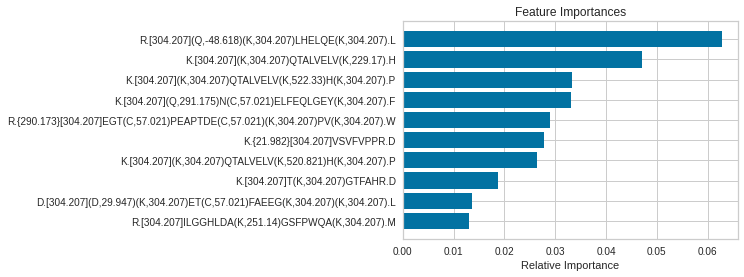

In [ ]:
results['Baseline'], baseline_top_feats = evaluate(random_grid, baseline_train_data, y_train, baseline_test_data, y_test)

In [ ]:
baseline_top_feats

['R.[304.207]ILGGHLDA(K,251.14)GSFPWQA(K,304.207).M',
 'D.[304.207](D,29.947)(K,304.207)ET(C,57.021)FAEEG(K,304.207)(K,304.207).L',
 'K.[304.207]T(K,304.207)GTFAHR.D',
 'K.[304.207](K,304.207)QTALVELV(K,520.821)H(K,304.207).P',
 'K.{21.982}[304.207]VSVFVPPR.D',
 'R.{290.173}[304.207]EGT(C,57.021)PEAPTDE(C,57.021)(K,304.207)PV(K,304.207).W',
 'K.[304.207](Q,291.175)N(C,57.021)ELFEQLGEY(K,304.207).F',
 'K.[304.207](K,304.207)QTALVELV(K,522.33)H(K,304.207).P',
 'K.[304.207](K,304.207)QTALVELV(K,229.17).H',
 'R.[304.207](Q,-48.618)(K,304.207)LHELQE(K,304.207).L']

Fitting 3 folds for each of 3 candidates, totalling 9 fits
0.7042160737812911 {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Performance 
 Accuracy = 0.869565 
 F1 Score = 0.869565 
 Precision = 0.833333 
 Recall = 0.909091
Model Performance
0.8695652173913043
<function f1_score at 0x7f78e6a21cb0>
0.8333333333333334
0.9090909090909091
[[10  2]
 [ 1 10]]


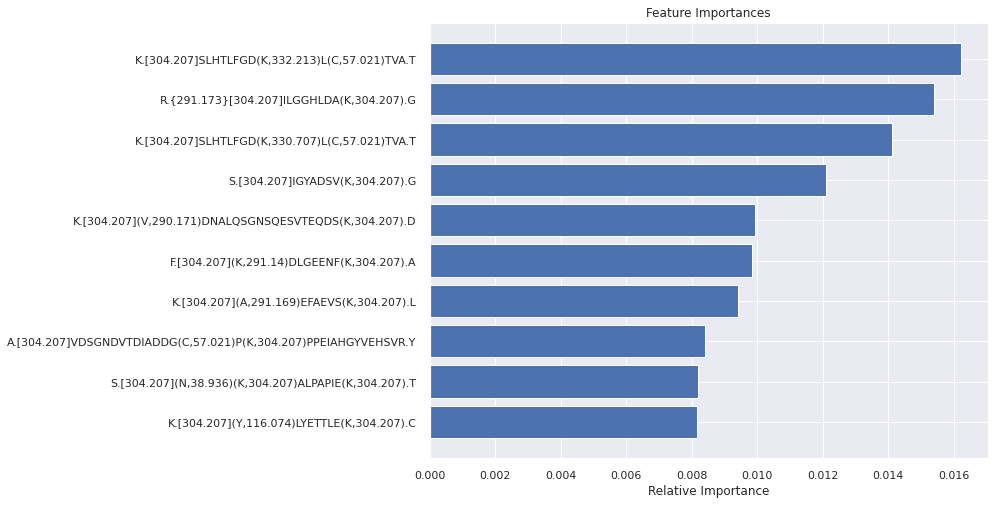

In [ ]:
results['Model 1'] = evaluate(random_grid, m_1_train_data, y_train, m_1_test_data, y_test)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
0.7759661835748792 {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Performance 
 Accuracy = 0.842105 
 F1 Score = 0.842105 
 Precision = 0.800000 
 Recall = 0.888889
Model Performance
0.8421052631578947
<function f1_score at 0x7f4aaf4dccb0>
0.8
0.8888888888888888
[[8 2]
 [1 8]]


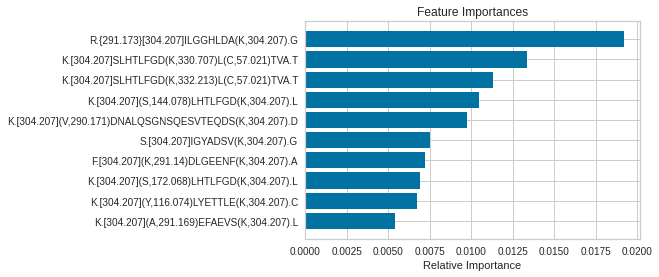

In [ ]:
results['Model 2'] = evaluate(random_grid, m_2_train_data, y_train, m_2_test_data, y_test)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
0.8031400966183576 {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}
Performance 
 Accuracy = 0.842105 
 F1 Score = 0.842105 
 Precision = 0.800000 
 Recall = 0.888889
Model Performance
0.8421052631578947
<function f1_score at 0x7f4aaf4dccb0>
0.8
0.8888888888888888
[[8 2]
 [1 8]]


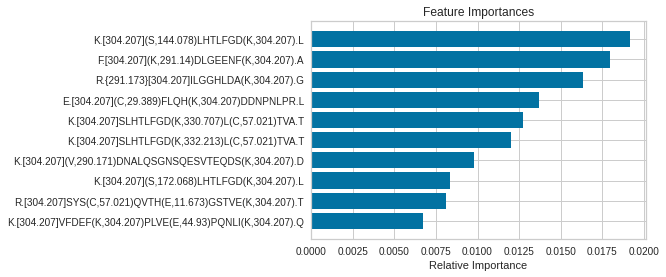

In [ ]:
results['Model 3'] = evaluate(random_grid, m_3_train_data, y_train, m_3_test_data, y_test)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
0.8031400966183576 {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Performance 
 Accuracy = 0.842105 
 F1 Score = 0.842105 
 Precision = 0.800000 
 Recall = 0.888889
Model Performance
0.8421052631578947
<function f1_score at 0x7f4aaf4dccb0>
0.8
0.8888888888888888
[[8 2]
 [1 8]]


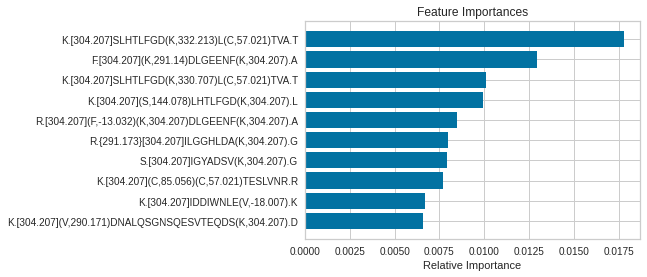

In [ ]:
results['Model 4'] = evaluate(random_grid, m_4_train_data, y_train, m_4_test_data, y_test)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
0.8037439613526569 {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}
Performance 
 Accuracy = 0.842105 
 F1 Score = 0.842105 
 Precision = 0.800000 
 Recall = 0.888889
Model Performance
0.8421052631578947
<function f1_score at 0x7f4aaf4dccb0>
0.8
0.8888888888888888
[[8 2]
 [1 8]]


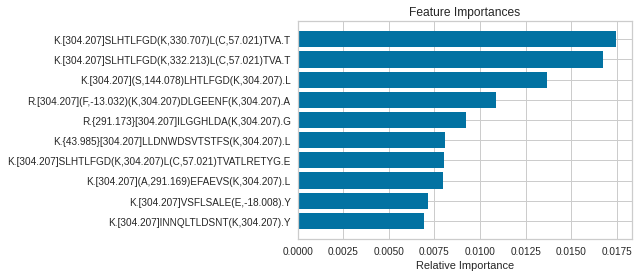

In [ ]:
results['Model 5'] = evaluate(random_grid, m_5_train_data, y_train, m_5_test_data, y_test)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
0.8170289855072465 {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Performance 
 Accuracy = 0.842105 
 F1 Score = 0.842105 
 Precision = 0.800000 
 Recall = 0.888889
Model Performance
0.8421052631578947
<function f1_score at 0x7f4aaf4dccb0>
0.8
0.8888888888888888
[[8 2]
 [1 8]]


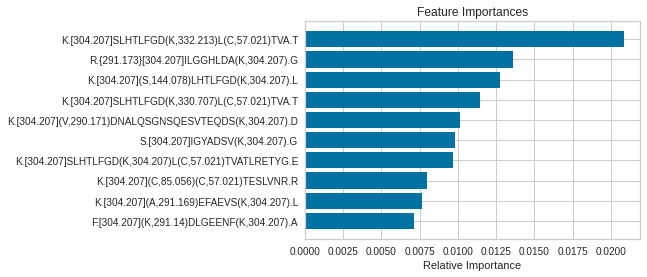

In [ ]:
results['Model 6'] = evaluate(random_grid, m_6_train_data, y_train, m_6_test_data, y_test)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
0.8170289855072465 {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Performance 
 Accuracy = 0.842105 
 F1 Score = 0.842105 
 Precision = 0.800000 
 Recall = 0.888889
Model Performance
0.8421052631578947
<function f1_score at 0x7f4aaf4dccb0>
0.8
0.8888888888888888
[[8 2]
 [1 8]]


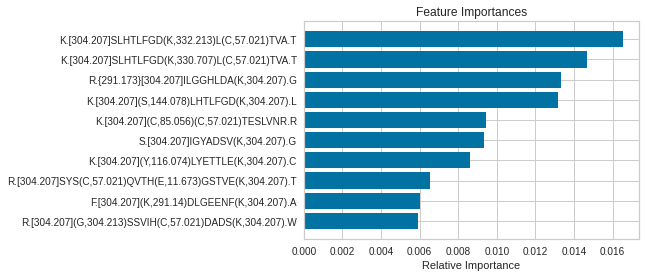

In [ ]:
results['Model 7'] = evaluate(random_grid, m_7_train_data, y_train, m_7_test_data, y_test)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
0.7753623188405797 {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Performance 
 Accuracy = 0.842105 
 F1 Score = 0.842105 
 Precision = 0.800000 
 Recall = 0.888889
Model Performance
0.8421052631578947
<function f1_score at 0x7f4aaf4dccb0>
0.8
0.8888888888888888
[[8 2]
 [1 8]]


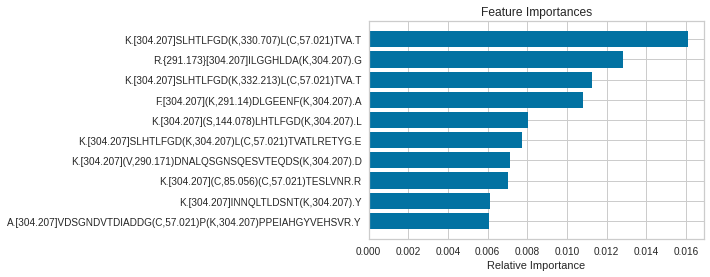

In [ ]:
results['Model 8'] = evaluate(random_grid, m_8_train_data, y_train, m_8_test_data, y_test)

In [ ]:
write_to_csv(results, "RF_removed_peptides.csv")

# Critical Evaluation

In [ ]:
def find_missing_value_count(peptide, df):
  df = df.copy()
  df.replace(0.0, np.nan, inplace=True)
  return df[peptide].isnull().sum()

In [ ]:
def plot_histogram(peptide, df):
  his_data = sns.displot(df, x=peptide, hue='Condition', binwidth=0.4)


In [ ]:
def get_p(peptide, df):
  covid_intensities = df[peptide][df.Condition == "Covid"].dropna()
  non_covid_intensities = df[peptide][df.Condition == "No-Covid"].dropna()
  wilcox_p = stats.ranksums(covid_intensities, non_covid_intensities)[1]
  #print("T-test:", stats.ttest_ind(covid_intensities, non_covid_intensities, equal_var = False))
  #print("Mann-Whitney rank test:", stats.mannwhitneyu(covid_intensities, non_covid_intensities, alternative = 'two-sided'))
  #print("Wilcoxon Rank Sum test:", wilcox_p)
  return wilcox_p


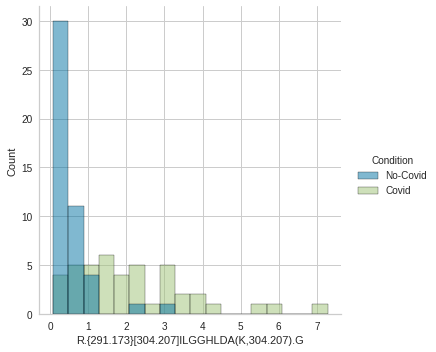

In [ ]:
plot_histogram('R.{291.173}[304.207]ILGGHLDA(K,304.207).G', variants_processed)

In [ ]:
def check_protein_level(protein, whole_df, variants_df):
  peptides = whole_df['Top Protein'== protein]
  peptides = list(peptides['Peptide'])
  for pept in peptides:
    p = get_p(pept, variants_df)


In [ ]:
variants.columns[:20]

Index(['rowid', 'ccms_row_id', 'Algorithm', 'Filename', 'Cluster_index',
       'Peptide', 'Unmodified_sequence', 'Charge',
       '_dyn_#Intensity_for_cluster',
       '_dyn_#Intensity_for_unmodified_sequence',
       'Num_G1_spectra_for_unmodified_sequence',
       'Num_G2_spectra_for_unmodified_sequence',
       'Num_G3_spectra_for_unmodified_sequence',
       'Num_G4_spectra_for_unmodified_sequence',
       'Num_G5_spectra_for_unmodified_sequence',
       'Num_G6_spectra_for_unmodified_sequence',
       '_dyn_#Empty.Empty.Empty..Empty.1_intensity_for_unmodified_sequence',
       '_dyn_#Healthy.HC1.Healthy..HC1.1_intensity_for_unmodified_sequence',
       '_dyn_#Healthy.HC10.Healthy..HC10.1_intensity_for_unmodified_sequence',
       '_dyn_#Healthy.HC12.Healthy..HC12.1_intensity_for_unmodified_sequence'],
      dtype='object')

In [ ]:
stat_test( "K.[304.207]ADD(K,304.207)ET(C,57.021)FAEEG(K,276.15)(K,304.207).L", variants_processed)

Wilcoxon Rank Sum test: 0.7466139868712289


In [ ]:
def heatmap(top_variants, df, size, index_present=True):
  variants_processed_for_heatmap = df.copy()
  variants_processed_for_heatmap.replace(0.0, np.nan, inplace=True)

  for index, row in variants_processed_for_heatmap.iterrows():
    
    if(index_present):
      condition = row['Condition']
      patient_id = index.split('.')[1]
    else:
      if(row['Condition'] == 1):
        condition = "Covid"
      else:
        condition = "No-Covid"
      patient_id = variants_processed_for_heatmap.loc[index,'Patients'].split('.')[1]
    variants_processed_for_heatmap.loc[index,'Patient Condition'] = condition+'.'+patient_id
    #print(condition+'.'+patient_id)
  
  #print(variants_processed_for_heatmap["New Index"])
  variants_processed_for_heatmap.set_index("Patient Condition", inplace=True)



  variants_processed_for_heatmap = variants_processed_for_heatmap.loc[:,list(top_variants)]
  variants_processed_for_heatmap.sort_index(axis=0, inplace=True)
  
  
  # z-score transform the peptide intensities
  variants_processed_for_heatmap = z_score(variants_processed_for_heatmap)[0]

  #print(variants_processed_for_heatmap)
  
  #transpose the matrix, so we can have peptides as rows
  variants_processed_for_heatmap = variants_processed_for_heatmap.T

  if('Covid.Patient-group-PT' in variants_processed_for_heatmap.columns or 'No-Covid.Patient-group-jbdz' in variants_processed_for_heatmap.columns or 'Covid.Patient-group-ZX' in variants_processed_for_heatmap):
    variants_processed_for_heatmap = variants_processed_for_heatmap.drop(labels=['Covid.Patient-group-PT','No-Covid.Patient-group-jbdz','Covid.Patient-group-ZX'], axis=1)
  #print(variants_processed_for_heatmap)

  cmap = sns.color_palette("viridis", as_cmap=True)
  sns.set(rc = {'figure.figsize':size})
  with sns.axes_style("white"):
      sns.heatmap(variants_processed_for_heatmap, cmap=cmap)


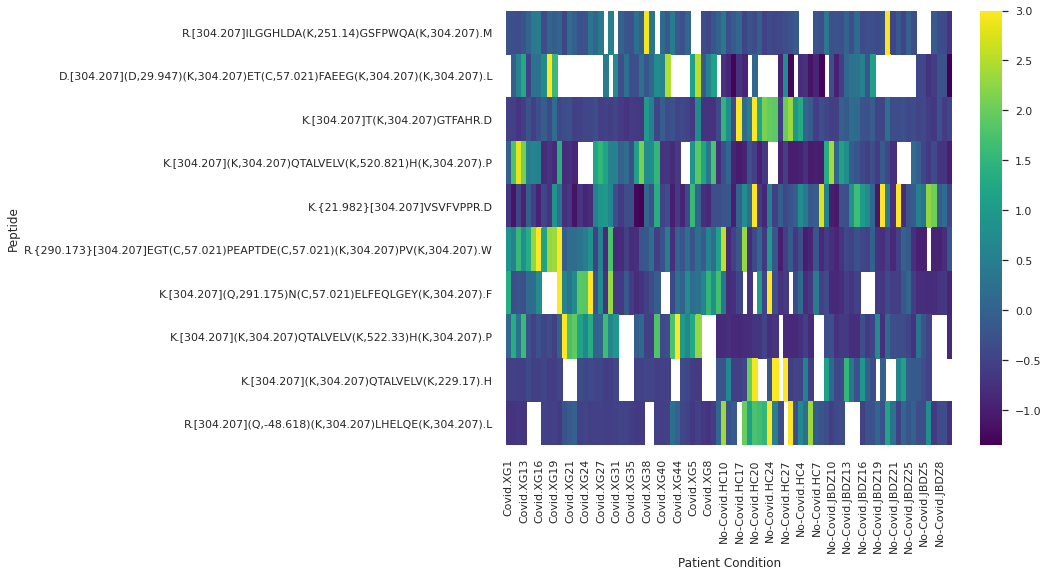

In [ ]:
heatmap(baseline_top_feats, variants_processed, (10,8))

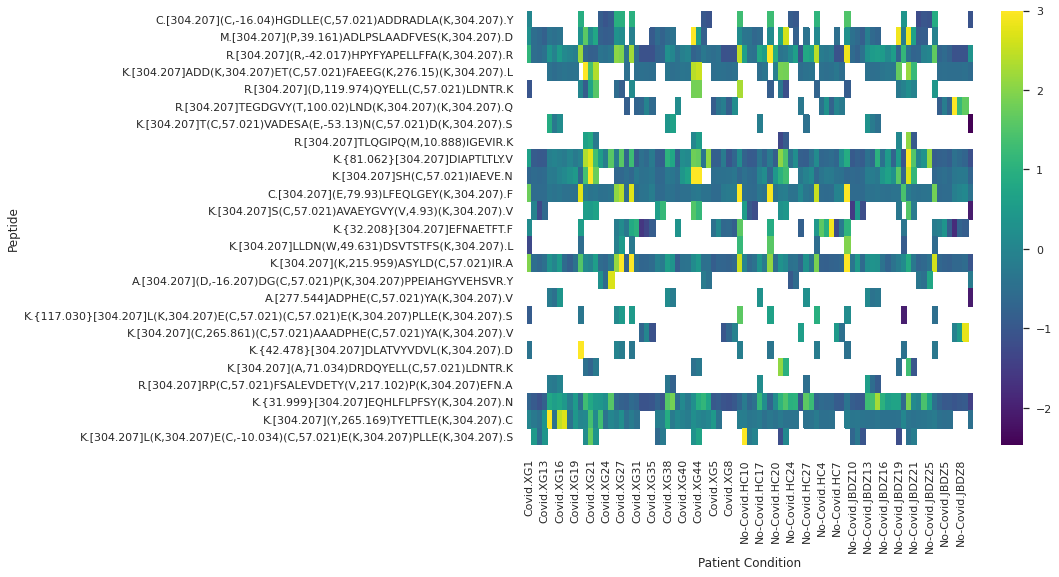

In [ ]:
#Heatmap for MissForest model
top_peptides = ["C.[304.207](C,-16.04)HGDLLE(C,57.021)ADDRADLA(K,304.207).Y", "M.[304.207](P,39.161)ADLPSLAADFVES(K,304.207).D",
                "R.[304.207](R,-42.017)HPYFYAPELLFFA(K,304.207).R", "K.[304.207]ADD(K,304.207)ET(C,57.021)FAEEG(K,276.15)(K,304.207).L",
                "R.[304.207](D,119.974)QYELL(C,57.021)LDNTR.K", "R.[304.207]TEGDGVY(T,100.02)LND(K,304.207)(K,304.207).Q",
                  "K.[304.207]T(C,57.021)VADESA(E,-53.13)N(C,57.021)D(K,304.207).S", "R.[304.207]TLQGIPQ(M,10.888)IGEVIR.K",
                  "K.{81.062}[304.207]DIAPTLTLY.V",
                  "K.[304.207]SH(C,57.021)IAEVE.N",
                  "C.[304.207](E,79.93)LFEQLGEY(K,304.207).F",
                  "K.[304.207]S(C,57.021)AVAEYGVY(V,4.93)(K,304.207).V",
                  "K.{32.208}[304.207]EFNAETFT.F",
                  "K.[304.207]LLDN(W,49.631)DSVTSTFS(K,304.207).L",
                  "K.[304.207](K,215.959)ASYLD(C,57.021)IR.A",
                  "A.[304.207](D,-16.207)DG(C,57.021)P(K,304.207)PPEIAHGYVEHSVR.Y",
                  "A.[277.544]ADPHE(C,57.021)YA(K,304.207).V",
                  "K.{117.030}[304.207]L(K,304.207)E(C,57.021)(C,57.021)E(K,304.207)PLLE(K,304.207).S",
                  "K.[304.207](C,265.861)(C,57.021)AAADPHE(C,57.021)YA(K,304.207).V",
                  "K.{42.478}[304.207]DLATVYVDVL(K,304.207).D",
                  "K.[304.207](A,71.034)DRDQYELL(C,57.021)LDNTR.K",
                  "R.[304.207]RP(C,57.021)FSALEVDETY(V,217.102)P(K,304.207)EFN.A",
                  "K.{31.999}[304.207]EQHLFLPFSY(K,304.207).N",
                  "K.[304.207](Y,265.169)TYETTLE(K,304.207).C",
                  "K.[304.207]L(K,304.207)E(C,-10.034)(C,57.021)E(K,304.207)PLLE(K,304.207).S"]
heatmap(top_peptides,variants_processed)

In [ ]:
#Find and remove peptides with "thresh" number of missing values
def get_peptides_with_few_nas(top_peptides_list, thresh, df):
  missing_value_count = []
  for peptide in top_peptides_list:
    missing_value_count.append(find_missing_value_count(peptide, df))
  print(missing_value_count)
  peptides_with_few_nas = []
  for i in range(len(missing_value_count)):
    if(missing_value_count[i] < thresh):
      peptides_with_few_nas.append(top_peptides[i])
  return peptides_with_few_nas

In [ ]:
peptides_with_few_nas = get_peptides_with_few_nas(top_peptides, 45, variants_processed)

[66, 36, 0, 32, 66, 65, 78, 79, 0, 10, 0, 67, 53, 77, 0, 79, 78, 77, 77, 77, 79, 79, 0, 12, 68]


In [ ]:
peptides_with_few_nas

['M.[304.207](P,39.161)ADLPSLAADFVES(K,304.207).D',
 'R.[304.207](R,-42.017)HPYFYAPELLFFA(K,304.207).R',
 'K.[304.207]ADD(K,304.207)ET(C,57.021)FAEEG(K,276.15)(K,304.207).L',
 'K.{81.062}[304.207]DIAPTLTLY.V',
 'K.[304.207]SH(C,57.021)IAEVE.N',
 'C.[304.207](E,79.93)LFEQLGEY(K,304.207).F',
 'K.[304.207](K,215.959)ASYLD(C,57.021)IR.A',
 'K.{31.999}[304.207]EQHLFLPFSY(K,304.207).N',
 'K.[304.207](Y,265.169)TYETTLE(K,304.207).C']

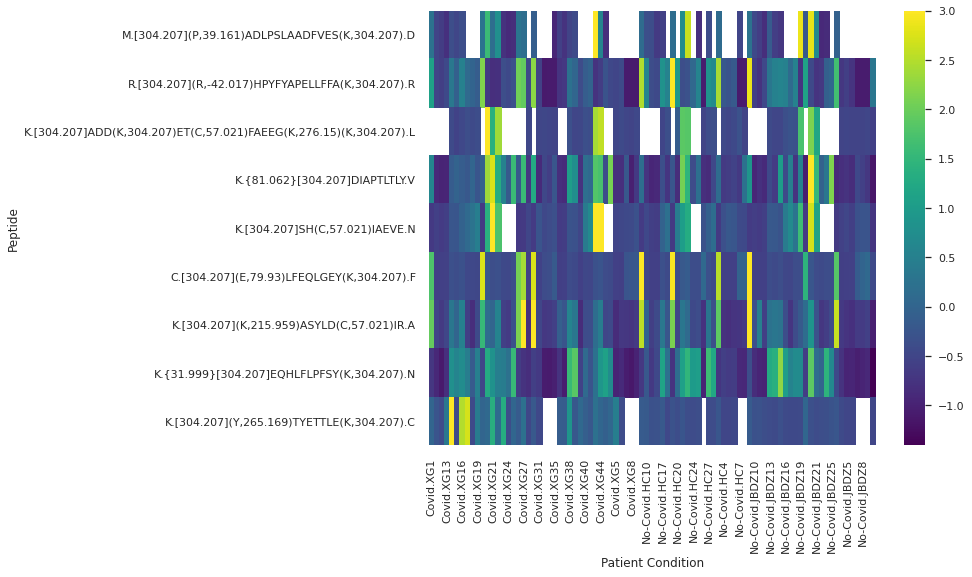

In [ ]:
heatmap(peptides_with_few_nas, variants_processed)

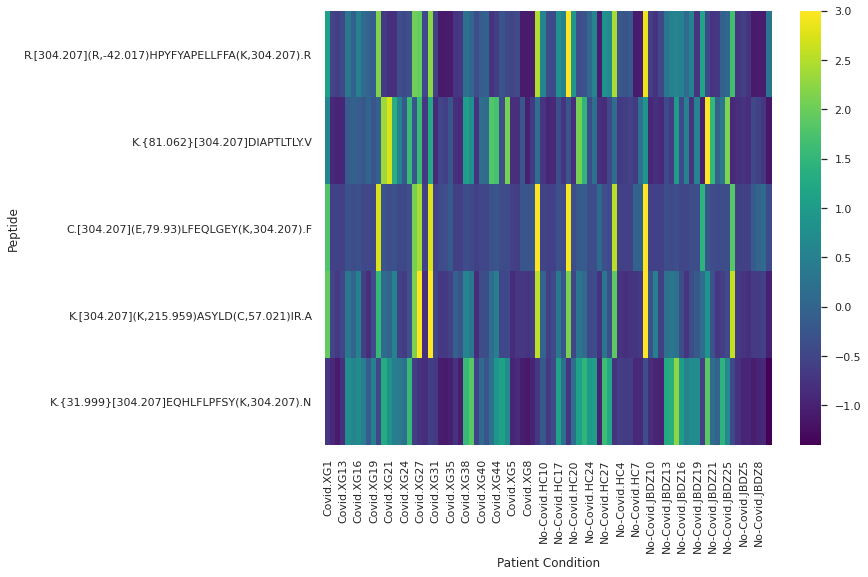

In [ ]:
final_top_peptides = ["R.[304.207](R,-42.017)HPYFYAPELLFFA(K,304.207).R", "K.{81.062}[304.207]DIAPTLTLY.V", "C.[304.207](E,79.93)LFEQLGEY(K,304.207).F",
                      "K.[304.207](K,215.959)ASYLD(C,57.021)IR.A", "K.{31.999}[304.207]EQHLFLPFSY(K,304.207).N"]
heatmap(final_top_peptides, variants_processed)

In [ ]:
def print_histogram_and_stat_test(peptide_list, df):
  for peptide in peptide_list:
    print(peptide)
    sns.displot(df, x=peptide, hue='Condition', binwidth=0.05)
    stat_test(peptide, df)
    print()

M.[304.207](P,39.161)ADLPSLAADFVES(K,304.207).D
T-test: Ttest_indResult(statistic=-0.11835382901216016, pvalue=0.9060571486241834)
Mann-Whitney rank test: MannwhitneyuResult(statistic=1051.0, pvalue=0.7384069805782116)

R.[304.207](R,-42.017)HPYFYAPELLFFA(K,304.207).R
T-test: Ttest_indResult(statistic=-1.1808489770068744, pvalue=0.2408491144552477)
Mann-Whitney rank test: MannwhitneyuResult(statistic=830.0, pvalue=0.1459510691560665)

K.[304.207]ADD(K,304.207)ET(C,57.021)FAEEG(K,276.15)(K,304.207).L
T-test: Ttest_indResult(statistic=0.5521961975656539, pvalue=0.582427658797122)
Mann-Whitney rank test: MannwhitneyuResult(statistic=1050.5, pvalue=0.7440581829310549)

K.{81.062}[304.207]DIAPTLTLY.V
T-test: Ttest_indResult(statistic=1.497249833311934, pvalue=0.1380167561023763)
Mann-Whitney rank test: MannwhitneyuResult(statistic=1207.0, pvalue=0.11337002208885917)

K.[304.207]SH(C,57.021)IAEVE.N
T-test: Ttest_indResult(statistic=0.7263379839340887, pvalue=0.47013550719823816)
Mann-Whitney

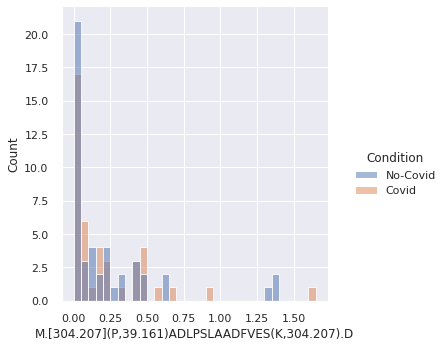

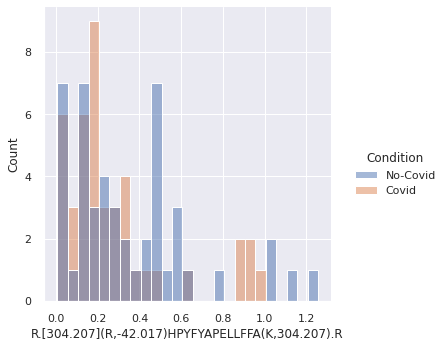

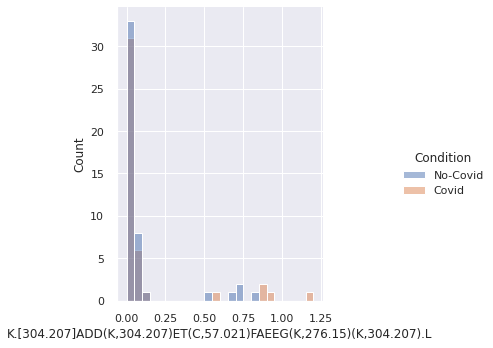

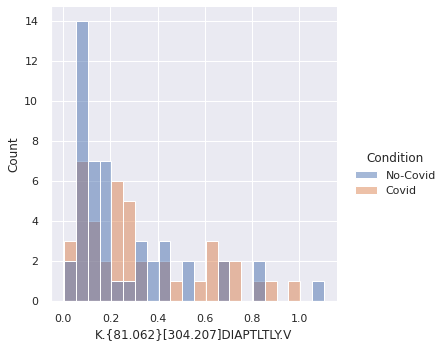

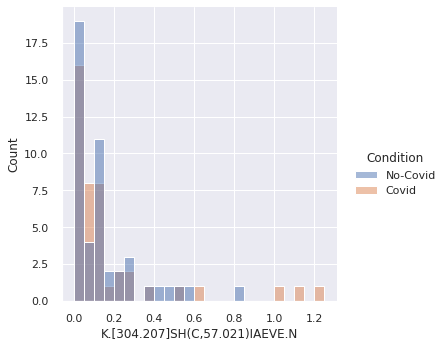

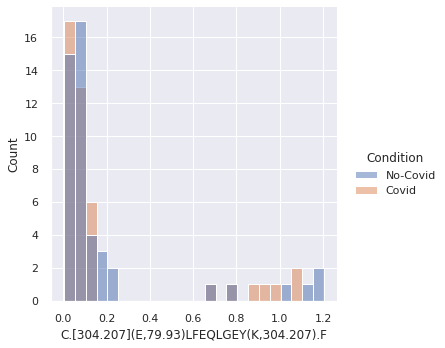

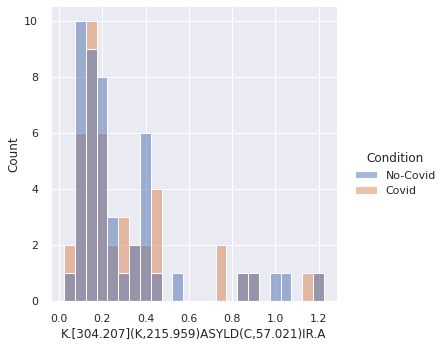

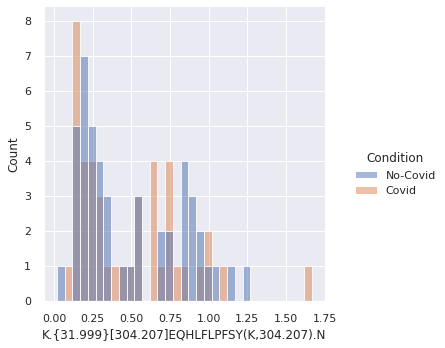

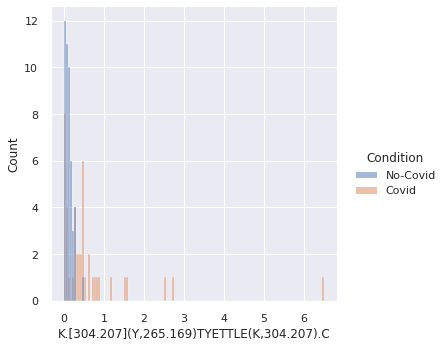

In [ ]:
print_histogram_and_stat_test(peptides_with_few_nas, variants_processed)

R.[304.207](R,-42.017)HPYFYAPELLFFA(K,304.207).R
T-test: Ttest_indResult(statistic=-1.1808489770068744, pvalue=0.2408491144552477)
Mann-Whitney rank test: MannwhitneyuResult(statistic=830.0, pvalue=0.1459510691560665)

K.{81.062}[304.207]DIAPTLTLY.V
T-test: Ttest_indResult(statistic=1.497249833311934, pvalue=0.1380167561023763)
Mann-Whitney rank test: MannwhitneyuResult(statistic=1207.0, pvalue=0.11337002208885917)

C.[304.207](E,79.93)LFEQLGEY(K,304.207).F
T-test: Ttest_indResult(statistic=0.09888863327067923, pvalue=0.9214536244630536)
Mann-Whitney rank test: MannwhitneyuResult(statistic=984.0, pvalue=0.8336522657214551)

K.[304.207](K,215.959)ASYLD(C,57.021)IR.A
T-test: Ttest_indResult(statistic=0.35272701632101977, pvalue=0.7251480273779911)
Mann-Whitney rank test: MannwhitneyuResult(statistic=1065.0, pvalue=0.6626953669021717)

K.{31.999}[304.207]EQHLFLPFSY(K,304.207).N
T-test: Ttest_indResult(statistic=-0.1488333139733751, pvalue=0.8820301626345352)
Mann-Whitney rank test: Mannwh

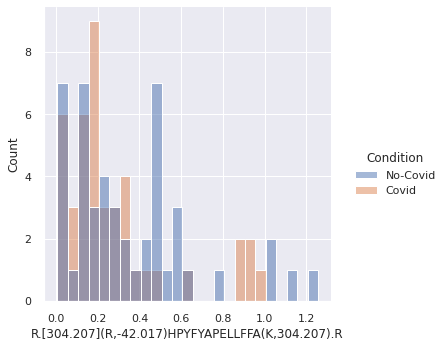

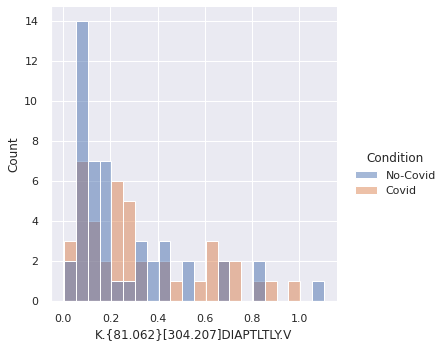

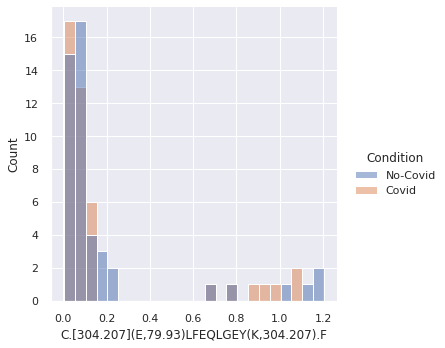

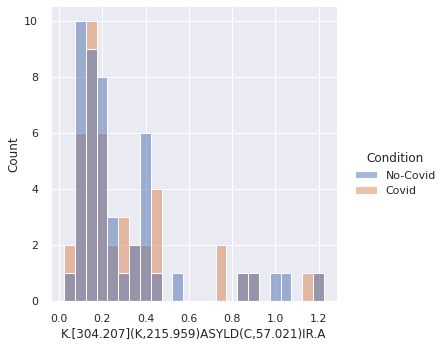

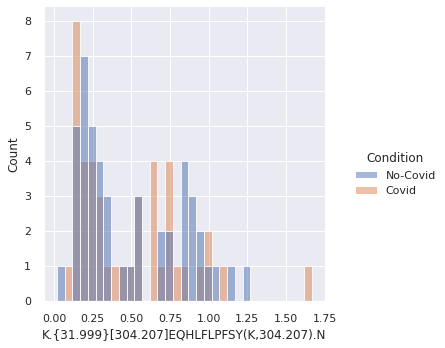

In [ ]:
print_histogram_and_stat_test(final_top_peptides, variants_processed)

In [ ]:
processed_data = "/content/drive/MyDrive/merged.csv"
missforest_variants = pd.read_csv(processed_data, sep="\t", low_memory=False)

In [ ]:
missforest_variants.replace(0.0,np.nan,inplace=True)

In [ ]:
missforest_variants

Patients  \
0                                   _dyn_#Healthy.HC1   
1                                  _dyn_#Healthy.HC10   
2                                  _dyn_#Healthy.HC12   
3                                  _dyn_#Healthy.HC13   
4                                  _dyn_#Healthy.HC17   
..                                                ...   
85               _dyn_#Symptomatic-non-COVID-19.JBDZ6   
86               _dyn_#Symptomatic-non-COVID-19.JBDZ7   
87               _dyn_#Symptomatic-non-COVID-19.JBDZ8   
88               _dyn_#Symptomatic-non-COVID-19.JBDZ9   
89  _dyn_#Symptomatic-non-COVID-19.Patient-group-jbdz   

    K.[304.207]GLEWIG(E,-64.055)IYHSGSPNYNPSL(K,304.207).S  \
0                                            1.167505        
1                                                 NaN        
2                                                 NaN        
3                                                 NaN        
4                                                 NaN        
..                                                ...        
85                                                NaN        
86                                                NaN        
87                                                NaN        
88                                                NaN        
89                                                NaN        

    R.[304.207]R(D,-28.005)AEAWFNE(K,304.207).S  \
0                                           NaN   
1                                     10.441582   
2                                      3.621786   
3                                      6.146458   
4                                      1.244000   
..                                          ...   
85                                          NaN   
86                                          NaN   
87                                          NaN   
88                                          NaN   
89                                     1.574453   

    -.{125.417}[304.207]EVQLVESGGGLVQPGGSLR.L  \
0                                    0.930832   
1                                         NaN   
2                                         NaN   
3                                         NaN   
4                                         NaN   
..                                        ...   
85                                        NaN   
86                                        NaN   
87                                        NaN   
88                                        NaN   
89                                        NaN   

    K.[304.207]ADD(K,304.207)ET(C,57.021)FAE(E,35.494)PTMRIR.E  \
0                                                 NaN            
1                                                 NaN            
2                                                 NaN            
3                                                 NaN            
4                                                 NaN            
..                                                ...            
85                                                NaN            
86                                                NaN            
87                                                NaN            
88                                                NaN            
89                                                NaN            

    Q.[304.207]LVESGG(G,44.034)LVQPGGSLR.L  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                 0.500522   
..                                     ...   
85                                     NaN   
86                                     NaN   
87                                     NaN   
88                                     NaN   
89                                     NaN   

    K.[304.207]QWIN(K,304.207)AVGD(K,304.207)LPE(C,57.021)EAGATLINE

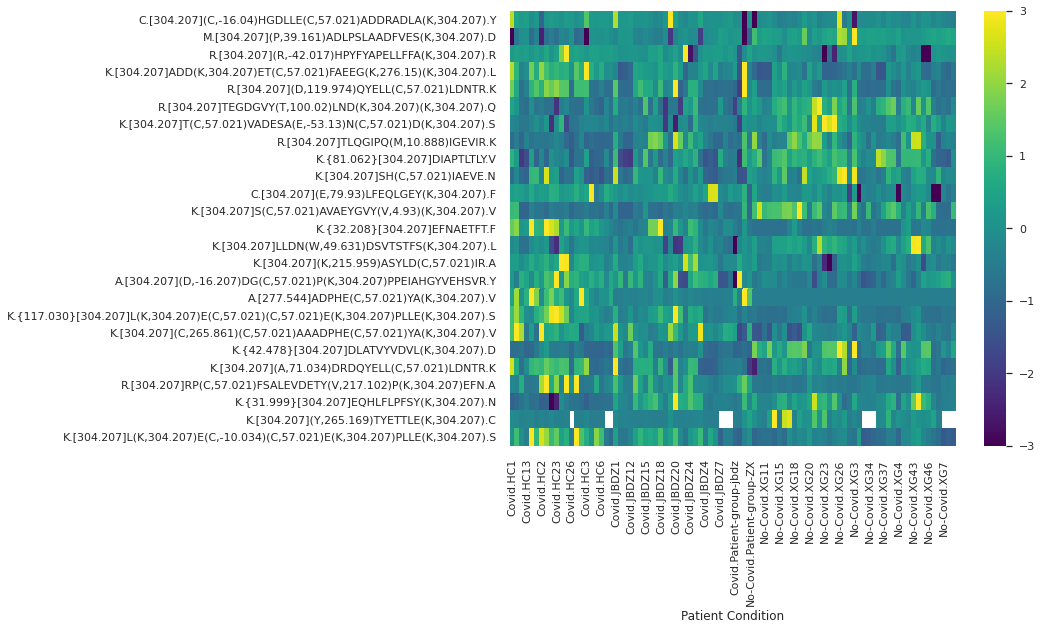

In [ ]:
heatmap(top_peptides, missforest_variants, index_present=False)

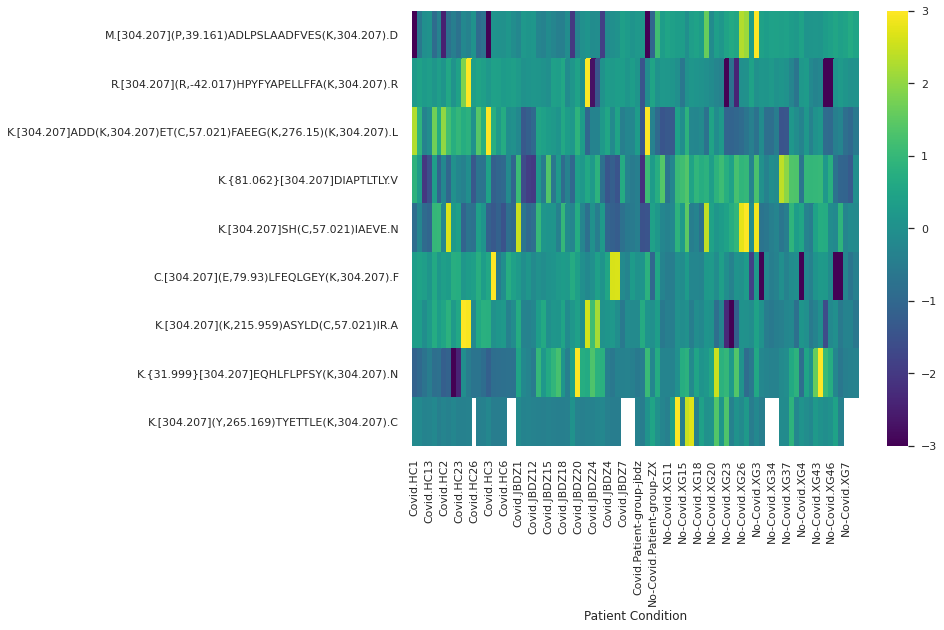

In [ ]:
heatmap(peptides_with_few_nas, missforest_variants, index_present=False)

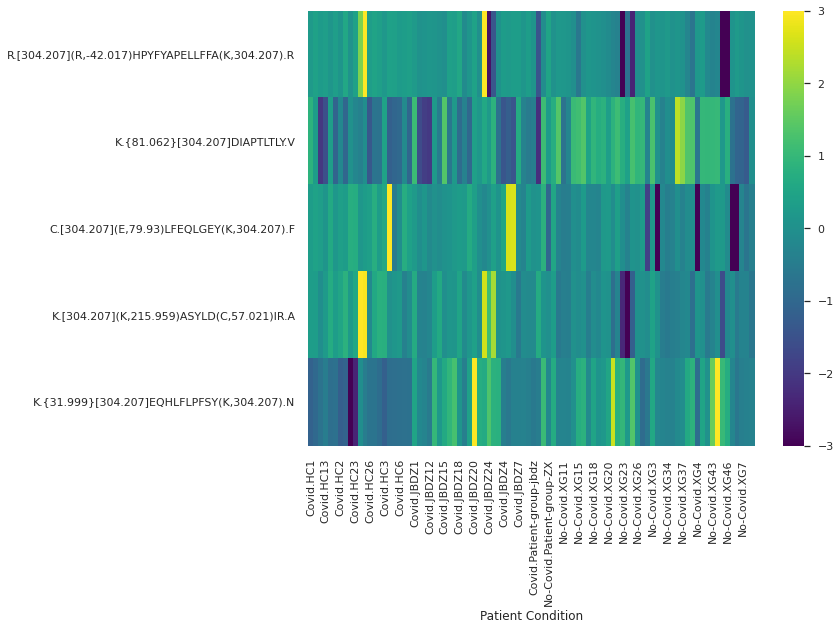

In [ ]:
heatmap(final_top_peptides, missforest_variants, index_present=False)

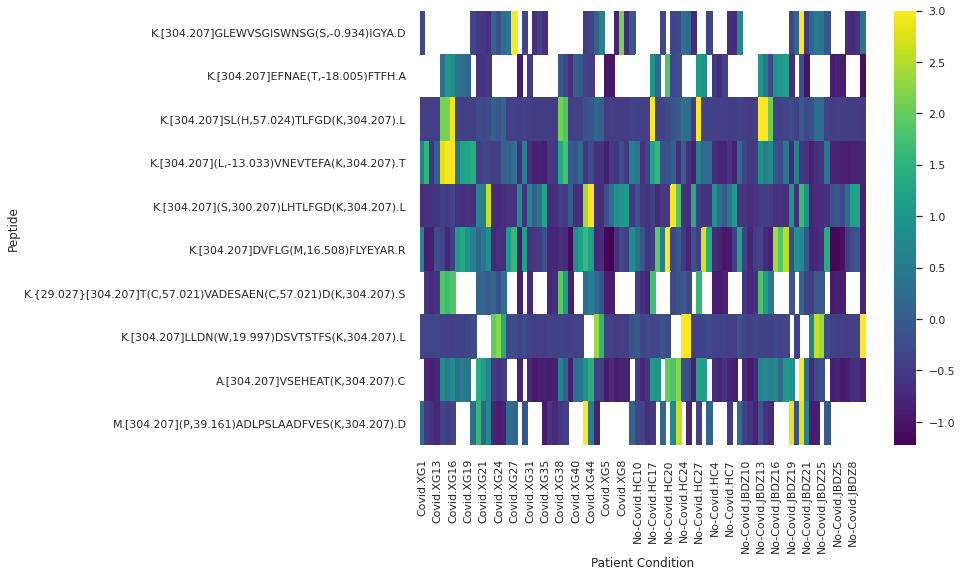

In [ ]:
top = ['K.[304.207]GLEWVSGISWNSG(S,-0.934)IGYA.D',
 'K.[304.207]EFNAE(T,-18.005)FTFH.A',
 'K.[304.207]SL(H,57.024)TLFGD(K,304.207).L',
 'K.[304.207](L,-13.033)VNEVTEFA(K,304.207).T',
 'K.[304.207](S,300.207)LHTLFGD(K,304.207).L',
 'K.[304.207]DVFLG(M,16.508)FLYEYAR.R',
 'K.{29.027}[304.207]T(C,57.021)VADESAEN(C,57.021)D(K,304.207).S',
 'K.[304.207]LLDN(W,19.997)DSVTSTFS(K,304.207).L',
 'A.[304.207]VSEHEAT(K,304.207).C',
 'M.[304.207](P,39.161)ADLPSLAADFVES(K,304.207).D']
heatmap(top, variants_processed, (10,8))

K.[304.207]GLEWVSGISWNSG(S,-0.934)IGYA.D
T-test: Ttest_indResult(statistic=-0.010148025709723346, pvalue=0.9919261903526451)
Mann-Whitney rank test: MannwhitneyuResult(statistic=1029.0, pvalue=0.8775806585665321)
Wilcoxon Rank Sum test: RanksumsResult(statistic=0.14943712323590588, pvalue=0.8812087204826058)

K.[304.207]EFNAE(T,-18.005)FTFH.A
T-test: Ttest_indResult(statistic=-0.1478912227792699, pvalue=0.8827807725543082)
Mann-Whitney rank test: MannwhitneyuResult(statistic=985.5, pvalue=0.8332122501561869)
Wilcoxon Rank Sum test: RanksumsResult(statistic=-0.20194205842689986, pvalue=0.8399620214904698)

K.[304.207]SL(H,57.024)TLFGD(K,304.207).L
T-test: Ttest_indResult(statistic=-0.44886983373394396, pvalue=0.654658478213668)
Mann-Whitney rank test: MannwhitneyuResult(statistic=932.0, pvalue=0.5286558378248692)
Wilcoxon Rank Sum test: RanksumsResult(statistic=-0.6340980634604655, pvalue=0.5260168265096837)

K.[304.207](L,-13.033)VNEVTEFA(K,304.207).T
T-test: Ttest_indResult(statistic=

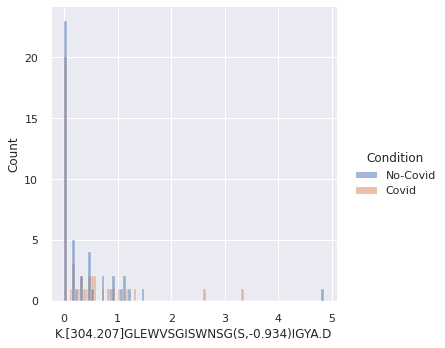

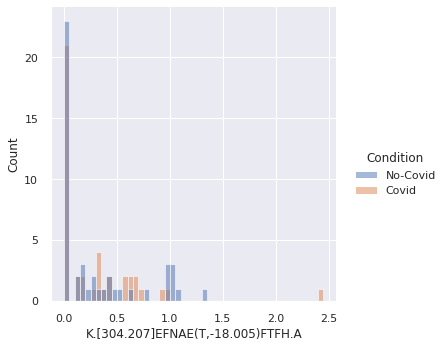

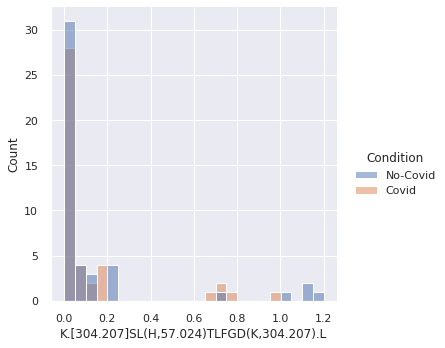

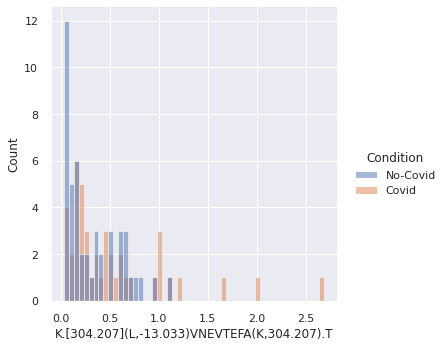

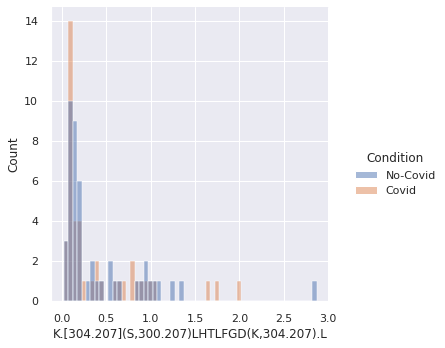

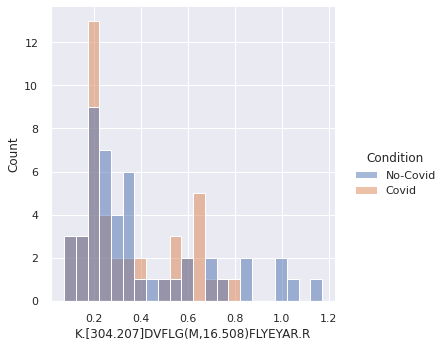

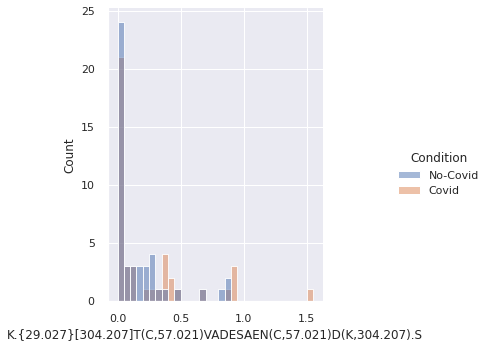

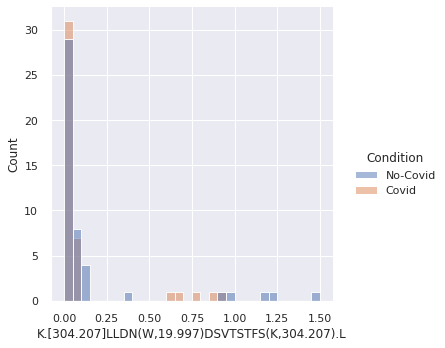

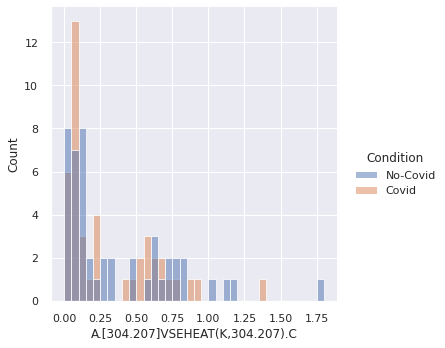

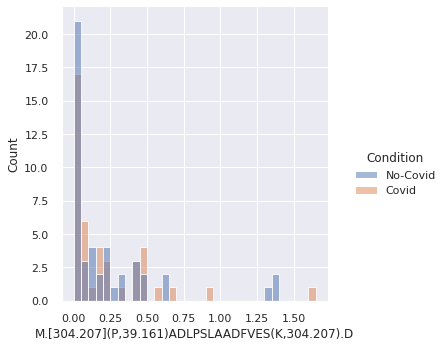

In [ ]:
print_histogram_and_stat_test(top, variants_processed)

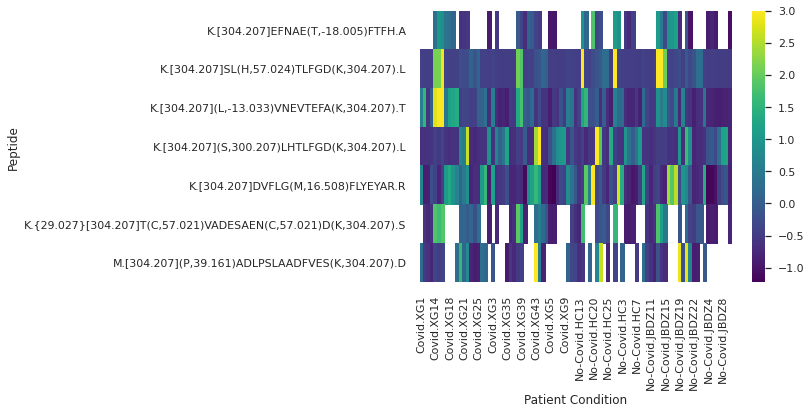

In [ ]:
# Protein: sp|P02768|ALBU_HUMAN
peptides_from_same_protein = ['K.[304.207]EFNAE(T,-18.005)FTFH.A','K.[304.207]SL(H,57.024)TLFGD(K,304.207).L','K.[304.207](L,-13.033)VNEVTEFA(K,304.207).T',
                              'K.[304.207](S,300.207)LHTLFGD(K,304.207).L','K.[304.207]DVFLG(M,16.508)FLYEYAR.R','K.{29.027}[304.207]T(C,57.021)VADESAEN(C,57.021)D(K,304.207).S',
                              'M.[304.207](P,39.161)ADLPSLAADFVES(K,304.207).D']
            
heatmap(peptides_from_same_protein, variants_processed, (7,5))

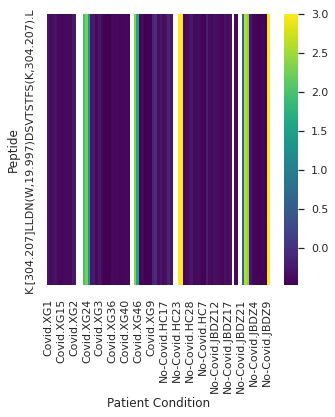

In [ ]:
# Parent protein: sp|P02647|APOA1_HUMAN
peptides_from_same_protein = ['K.[304.207]LLDN(W,19.997)DSVTSTFS(K,304.207).L']
heatmap(peptides_from_same_protein, variants_processed, (5,5))

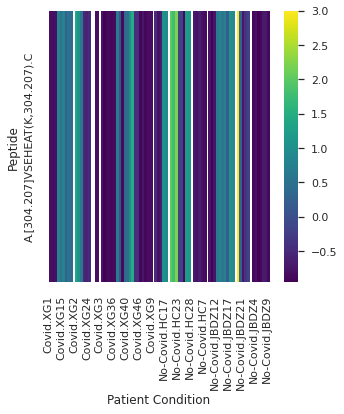

In [ ]:
# Parent protein: sp|P02787|TRFE_HUMAN
peptides_from_same_protein = ['A.[304.207]VSEHEAT(K,304.207).C']
heatmap(peptides_from_same_protein, variants_processed,(5,5))

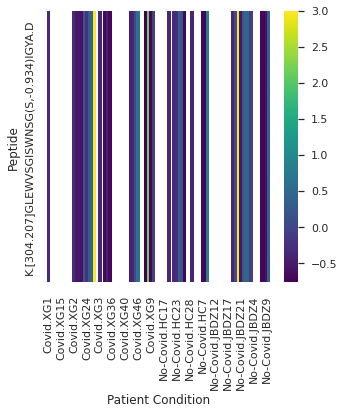

In [ ]:
# Parent protein: sp|P01782|HV309_HUMAN
peptides_from_same_protein = ['K.[304.207]GLEWVSGISWNSG(S,-0.934)IGYA.D']
heatmap(peptides_from_same_protein, variants_processed,(5,5))

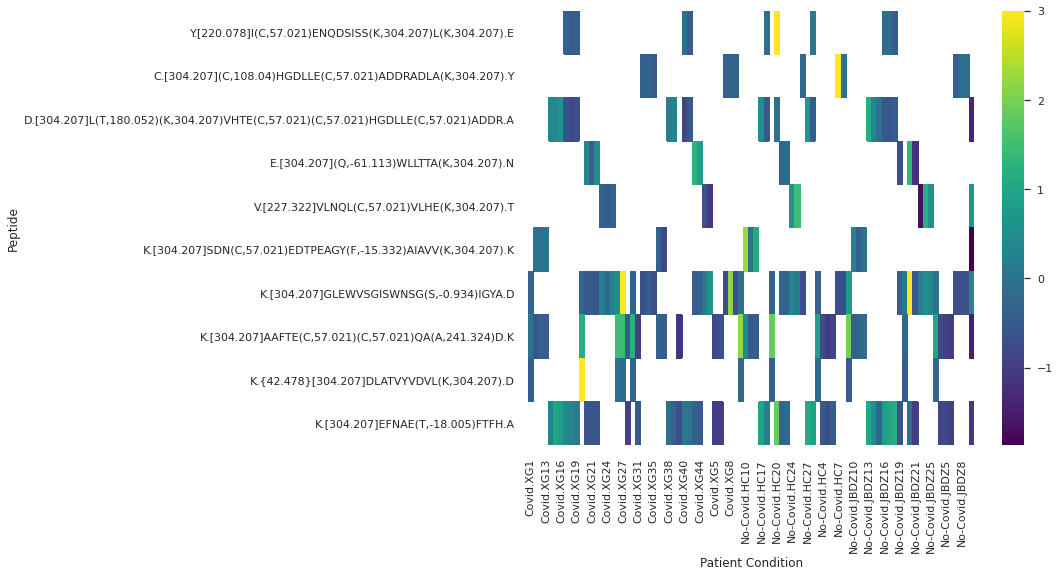

In [ ]:
top = ['Y.[220.078]I(C,57.021)ENQDSISS(K,304.207)L(K,304.207).E',
'C.[304.207](C,108.04)HGDLLE(C,57.021)ADDRADLA(K,304.207).Y',
'D.[304.207]L(T,180.052)(K,304.207)VHTE(C,57.021)(C,57.021)HGDLLE(C,57.021)ADDR.A',
'E.[304.207](Q,-61.113)WLLTTA(K,304.207).N',
'V.[227.322]VLNQL(C,57.021)VLHE(K,304.207).T',
'K.[304.207]SDN(C,57.021)EDTPEAGY(F,-15.332)AIAVV(K,304.207).K',
'K.[304.207]GLEWVSGISWNSG(S,-0.934)IGYA.D',
'K.[304.207]AAFTE(C,57.021)(C,57.021)QA(A,241.324)D.K',
'K.{42.478}[304.207]DLATVYVDVL(K,304.207).D',
'K.[304.207]EFNAE(T,-18.005)FTFH.A']
heatmap(top, variants_processed, (10,8))

In [ ]:
def two_D_plot(peptide_1, peptide_2, df):
  sns.jointplot(x=variants_processed[peptide_1],
              y=variants_processed[peptide_2],
              hue=variants_processed['Condition'])


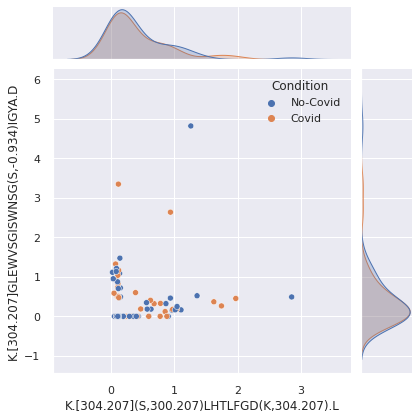

In [ ]:
two_D_plot('K.[304.207](S,300.207)LHTLFGD(K,304.207).L','K.[304.207]GLEWVSGISWNSG(S,-0.934)IGYA.D', variants_processed)

In [ ]:
len(peptide_features)

548

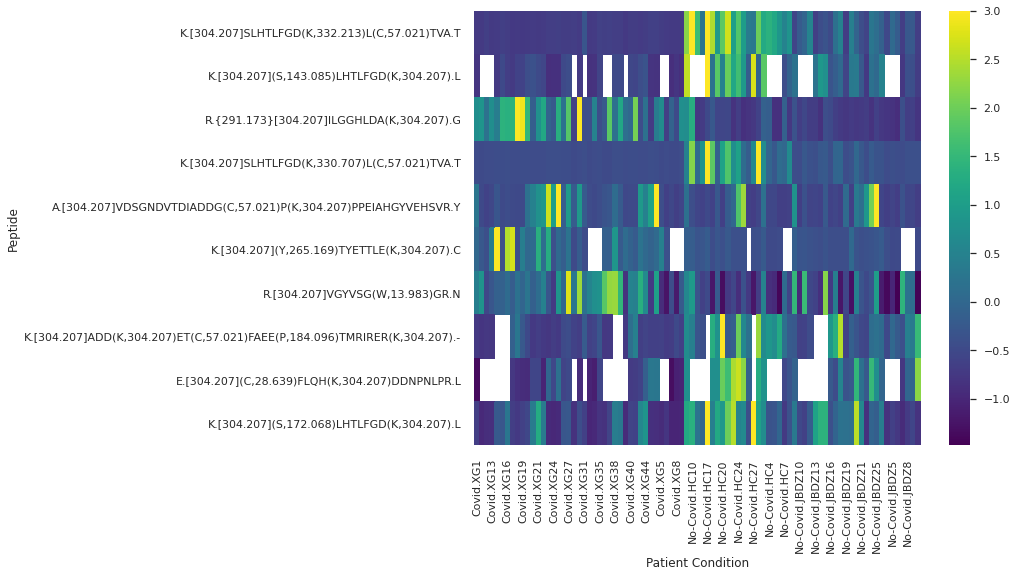

In [ ]:
model_7 = ["K.[304.207]SLHTLFGD(K,332.213)L(C,57.021)TVA.T", 'K.[304.207](S,143.085)LHTLFGD(K,304.207).L','R.{291.173}[304.207]ILGGHLDA(K,304.207).G', 'K.[304.207]SLHTLFGD(K,330.707)L(C,57.021)TVA.T','A.[304.207]VDSGNDVTDIADDG(C,57.021)P(K,304.207)PPEIAHGYVEHSVR.Y','K.[304.207](Y,265.169)TYETTLE(K,304.207).C','R.[304.207]VGYVSG(W,13.983)GR.N','K.[304.207]ADD(K,304.207)ET(C,57.021)FAEE(P,184.096)TMRIRER(K,304.207).-','E.[304.207](C,28.639)FLQH(K,304.207)DDNPNLPR.L','K.[304.207](S,172.068)LHTLFGD(K,304.207).L']
heatmap(model_7, variants_processed, (10,8))

In [ ]:
stat_test("K.[304.207]SLHTLFGD(K,332.213)L(C,57.021)TVA.T", variants_processed)

T-test: Ttest_indResult(statistic=-7.607650590906992, pvalue=7.168193419602132e-10)
Mann-Whitney rank test: MannwhitneyuResult(statistic=101.0, pvalue=2.0946315871243666e-13)
Wilcoxon Rank Sum test: RanksumsResult(statistic=-7.346652085570616, pvalue=2.0323295477438377e-13)


K.[304.207]SLHTLFGD(K,332.213)L(C,57.021)TVA.T
T-test: Ttest_indResult(statistic=-7.607650590906992, pvalue=7.168193419602132e-10)
Mann-Whitney rank test: MannwhitneyuResult(statistic=101.0, pvalue=2.0946315871243666e-13)
Wilcoxon Rank Sum test: RanksumsResult(statistic=-7.346652085570616, pvalue=2.0323295477438377e-13)

K.[304.207](S,143.085)LHTLFGD(K,304.207).L
T-test: Ttest_indResult(statistic=-4.781472228382218, pvalue=1.3887241113498297e-05)
Mann-Whitney rank test: MannwhitneyuResult(statistic=566.0, pvalue=0.00030276567896226985)
Wilcoxon Rank Sum test: RanksumsResult(statistic=-3.5905297988302793, pvalue=0.00033000649743539684)

R.{291.173}[304.207]ILGGHLDA(K,304.207).G
T-test: Ttest_indResult(statistic=6.734221944184423, pvalue=1.327143222459671e-08)
Mann-Whitney rank test: MannwhitneyuResult(statistic=1846.0, pvalue=1.5316963481533658e-11)
Wilcoxon Rank Sum test: RanksumsResult(statistic=6.748903592626993, pvalue=1.4896652521460967e-11)

K.[304.207]SLHTLFGD(K,330.707)L(C,57.02

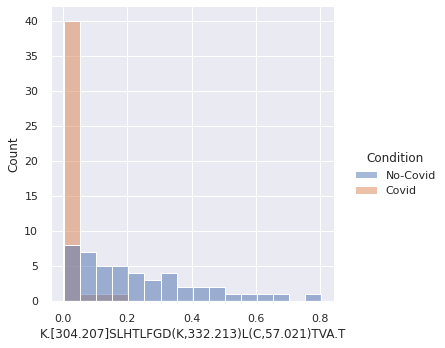

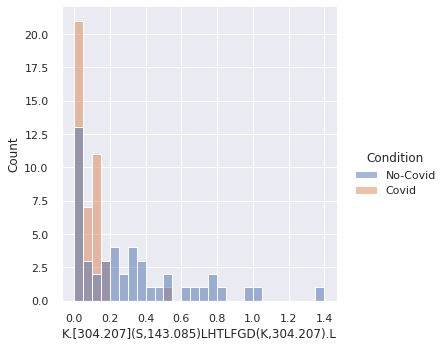

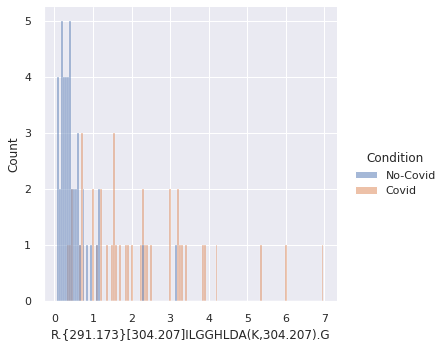

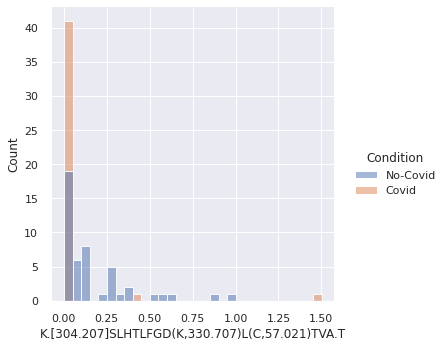

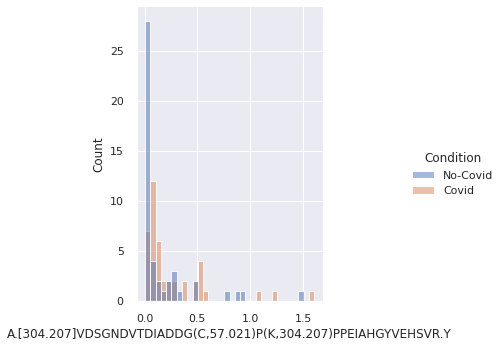

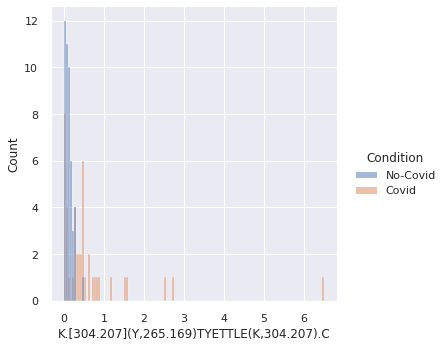

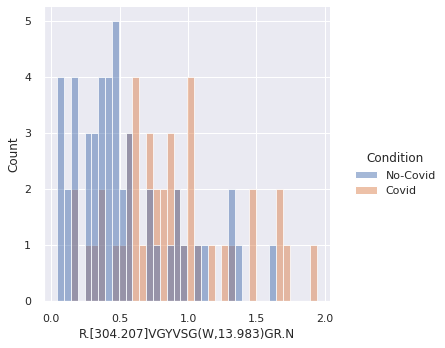

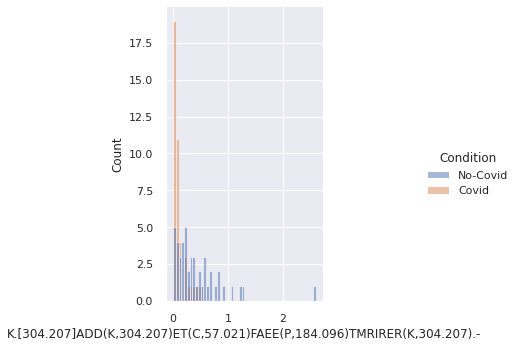

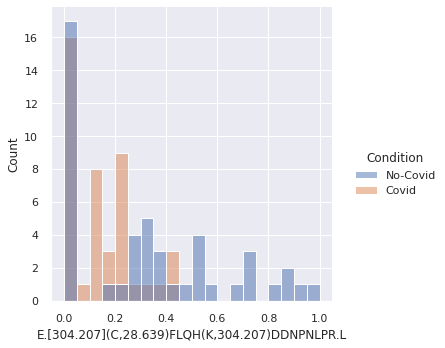

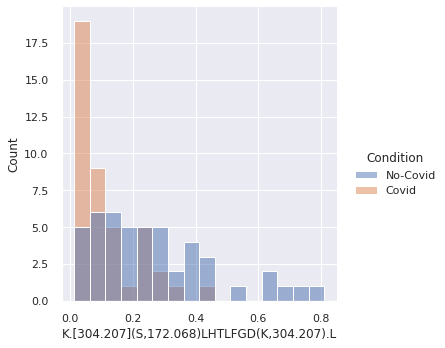

In [ ]:
print_histogram_and_stat_test(model_7, variants_processed)

In [ ]:
plot_histogram("K.[304.207]SLHTLFGD(K,332.213)L(C,57.021)TVA.T", variants_processed)

In [ ]:
'variants_processed[peptide_1]

_dyn_#Healthy.HC1                                    0.000000
_dyn_#Healthy.HC10                                   6.645649
_dyn_#Healthy.HC12                                   3.391896
_dyn_#Healthy.HC13                                   1.919552
_dyn_#Healthy.HC17                                   0.000000
                                                       ...   
_dyn_#Symptomatic-non-COVID-19.JBDZ6                 0.000000
_dyn_#Symptomatic-non-COVID-19.JBDZ7                 0.000000
_dyn_#Symptomatic-non-COVID-19.JBDZ8                 0.000000
_dyn_#Symptomatic-non-COVID-19.JBDZ9                 0.000000
_dyn_#Symptomatic-non-COVID-19.Patient-group-jbdz    0.000000
Name: K.[304.207]GARLIPEMDQIFTEVEMTTLE(K,304.207).V, Length: 90, dtype: float64

In [ ]:
peptide_features.shape

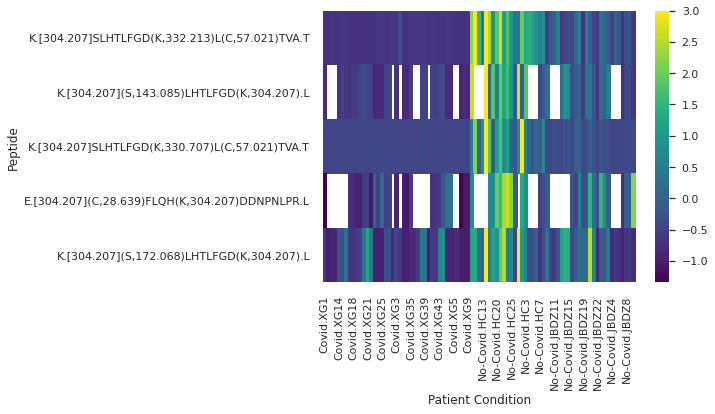

In [ ]:
# Protein: sp|P02768|ALBU_HUMAN
peptides_from_same_protein = ['K.[304.207]SLHTLFGD(K,332.213)L(C,57.021)TVA.T','K.[304.207](S,143.085)LHTLFGD(K,304.207).L',
                              'K.[304.207]SLHTLFGD(K,330.707)L(C,57.021)TVA.T', 'E.[304.207](C,28.639)FLQH(K,304.207)DDNPNLPR.L', 'K.[304.207](S,172.068)LHTLFGD(K,304.207).L']
            
heatmap(peptides_from_same_protein, variants_processed, (7,5))

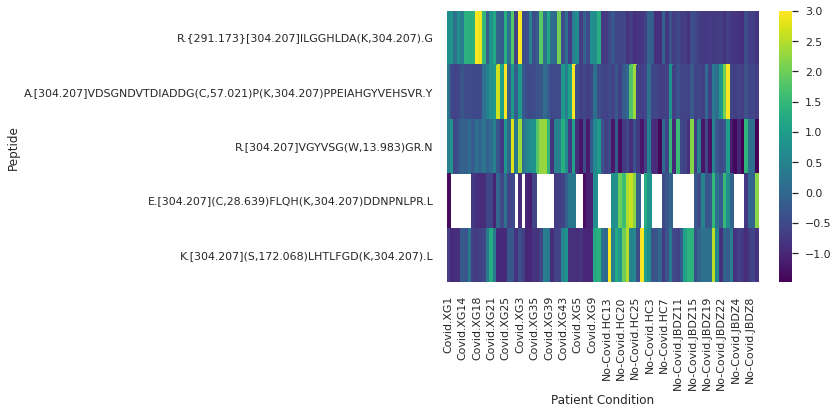

In [ ]:
# Protein: sp|P00738|HPT_HUMAN
peptides_from_same_protein = ['R.{291.173}[304.207]ILGGHLDA(K,304.207).G','A.[304.207]VDSGNDVTDIADDG(C,57.021)P(K,304.207)PPEIAHGYVEHSVR.Y',
                              'R.[304.207]VGYVSG(W,13.983)GR.N', 'E.[304.207](C,28.639)FLQH(K,304.207)DDNPNLPR.L', 'K.[304.207](S,172.068)LHTLFGD(K,304.207).L']
            
heatmap(peptides_from_same_protein, variants_processed, (7,5))

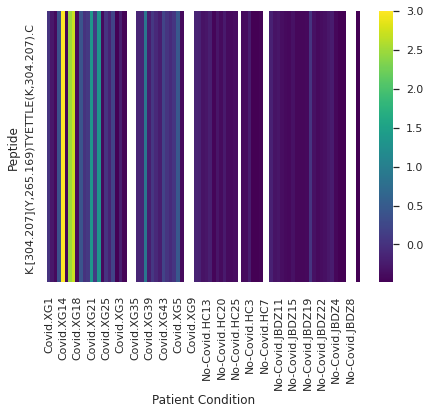

In [ ]:
# Protein: sp|P00738|HPT_HUMAN
peptides_from_same_protein = ['K.[304.207](Y,265.169)TYETTLE(K,304.207).C']
            
heatmap(peptides_from_same_protein, variants_processed, (7,5))

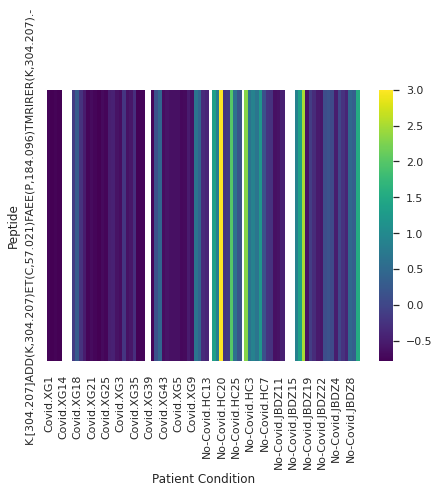

In [ ]:
peptides_from_same_protein = ['K.[304.207]ADD(K,304.207)ET(C,57.021)FAEE(P,184.096)TMRIRER(K,304.207).-']
            
heatmap(peptides_from_same_protein, variants_processed, (7,5))

K.[304.207]SLHTLFGD(K,330.707)L(C,57.021)TVA.T
T-test: Ttest_indResult(statistic=-2.448054453504764, pvalue=0.016377716764510785)
Mann-Whitney rank test: MannwhitneyuResult(statistic=198.0, pvalue=5.41414583007778e-11)
Wilcoxon Rank Sum test: RanksumsResult(statistic=-6.563116898874245, pvalue=5.26945040729312e-11)

S.[304.207]IGYADSV(K,304.207).G
T-test: Ttest_indResult(statistic=-4.389474944729847, pvalue=4.065455303959575e-05)
Mann-Whitney rank test: MannwhitneyuResult(statistic=404.0, pvalue=9.826799604691604e-07)
Wilcoxon Rank Sum test: RanksumsResult(statistic=-4.899114337436591, pvalue=9.626961329120767e-07)

R.{291.173}[304.207]ILGGHLDA(K,304.207).G
T-test: Ttest_indResult(statistic=6.734221944184423, pvalue=1.327143222459671e-08)
Mann-Whitney rank test: MannwhitneyuResult(statistic=1846.0, pvalue=1.5316963481533658e-11)
Wilcoxon Rank Sum test: RanksumsResult(statistic=6.748903592626993, pvalue=1.4896652521460967e-11)



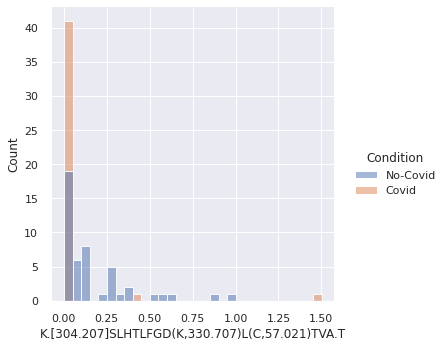

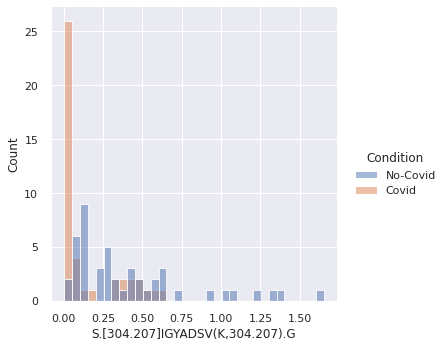

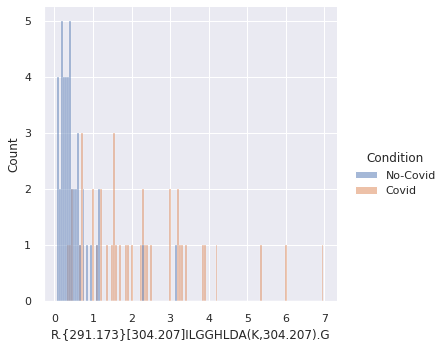

In [ ]:
top_3 = ['K.[304.207]SLHTLFGD(K,330.707)L(C,57.021)TVA.T', 'S.[304.207]IGYADSV(K,304.207).G', 'R.{291.173}[304.207]ILGGHLDA(K,304.207).G']
print_histogram_and_stat_test(top_3, variants_processed)

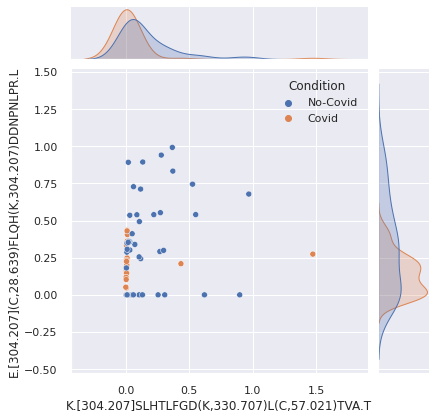

In [ ]:
two_D_plot('K.[304.207]SLHTLFGD(K,330.707)L(C,57.021)TVA.T', 'E.[304.207](C,28.639)FLQH(K,304.207)DDNPNLPR.L', variants_processed)

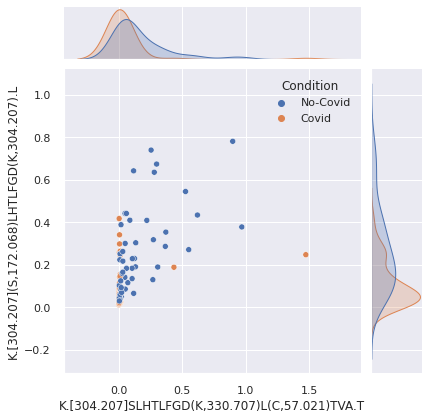

In [ ]:
two_D_plot('K.[304.207]SLHTLFGD(K,330.707)L(C,57.021)TVA.T', 'K.[304.207](S,172.068)LHTLFGD(K,304.207).L', variants_processed)

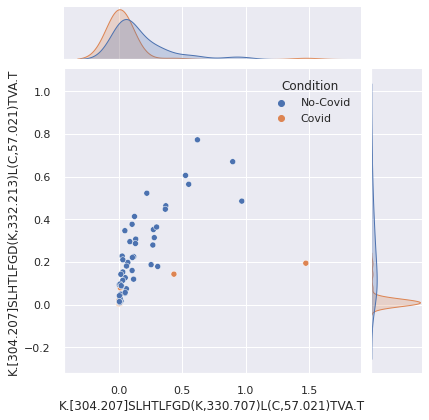

In [ ]:
two_D_plot('K.[304.207]SLHTLFGD(K,330.707)L(C,57.021)TVA.T', 'K.[304.207]SLHTLFGD(K,332.213)L(C,57.021)TVA.T', variants_processed)

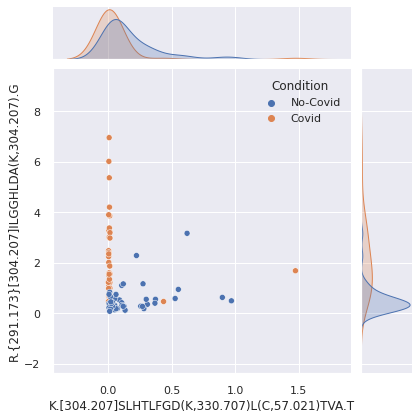

In [ ]:

two_D_plot('K.[304.207]SLHTLFGD(K,330.707)L(C,57.021)TVA.T', 'R.{291.173}[304.207]ILGGHLDA(K,304.207).G', variants_processed)

In [ ]:
# we only need the intensities for each peptide, noted as "...intensity_for_peptide_variant"
unmod_variants_processed = variants[
    ['Peptide'] + [c for c in variants.columns if 'intensity_for_unmodified_sequence' in c]
]

#set the index to be each Peptide
unmod_variants_processed = unmod_variants_processed.set_index('Peptide')

#transpose the matrix, so each column is a peptide
unmod_variants_processed = unmod_variants_processed.T

#only retain first two elements in the headers
unmod_variants_processed.index = unmod_variants_processed.index.map(lambda x: '.'.join(x.split('.')[:2]))

#set the condition to the first element
unmod_variants_processed['Condition'] = unmod_variants_processed.index.map(lambda x: x.split('.')[0])

print(unmod_variants_processed['Condition'].unique())
print(len_df(unmod_variants_processed, 'Condition', '_dyn_#Non-severe-COVID-19'))

unmod_variants_processed['Original Class'] = unmod_variants_processed['Condition']
unmod_variants_processed['Original Class'].replace({"_dyn_#Severe-COVID-19":"Severe-COVID-19", "_dyn_#Non-severe-COVID-19":"Non-severe-COVID-19",
                                         "_dyn_#Healthy":"Healthy", "_dyn_#Symptomatic-non-COVID-19":"Symptomatic-non-COVID-19"},
                                        inplace=True)

unmod_variants_processed['Condition'].replace({"_dyn_#Severe-COVID-19":"Covid", "_dyn_#Non-severe-COVID-19":"Covid",
                                         "_dyn_#Healthy":"No-Covid", "_dyn_#Symptomatic-non-COVID-19":"No-Covid"},
                                        inplace=True)

#only keep two conditions, for both severe and non-severe COVID-19
unmod_variants_processed = unmod_variants_processed[(unmod_variants_processed.Condition == "Covid") 
                             | (unmod_variants_processed.Condition == "No-Covid")]

#variants_processed  # print out to investigate

['_dyn_#Empty' '_dyn_#Healthy' '_dyn_#Non-severe-COVID-19' '_dyn_#Norm'
 '_dyn_#Severe-COVID-19' '_dyn_#Symptomatic-non-COVID-19']
25


In [ ]:
unmod_variants_processed

Peptide                                            K.[304.207]GARLIPEMDQIFTEVEMTTLE(K,304.207).V  \
_dyn_#Healthy.HC1                                                                       0.000000   
_dyn_#Healthy.HC10                                                                      6.645649   
_dyn_#Healthy.HC12                                                                      3.391896   
_dyn_#Healthy.HC13                                                                      1.919552   
_dyn_#Healthy.HC17                                                                      0.000000   
...                                                                                          ...   
_dyn_#Symptomatic-non-COVID-19.JBDZ6                                                    0.000000   
_dyn_#Symptomatic-non-COVID-19.JBDZ7                                                    0.000000   
_dyn_#Symptomatic-non-COVID-19.JBDZ8                                                    0.000000   
_dyn_#Symptomatic-non-COVID-19.JBDZ9                                                    0.000000   
_dyn_#Symptomatic-non-COVID-19.Patient-group-jbdz                                       0.000000   

Peptide                                            I.[304.207]FTEVEMTTLE(K,304.207).V  \
_dyn_#Healthy.HC1                                                            0.000000   
_dyn_#Healthy.HC10                                                           0.000000   
_dyn_#Healthy.HC12                                                           0.000000   
_dyn_#Healthy.HC13                                                           0.000000   
_dyn_#Healthy.HC17                                                           0.000000   
...                                                                               ...   
_dyn_#Symptomatic-non-COVID-19.JBDZ6                                         0.000000   
_dyn_#Symptomatic-non-COVID-19.JBDZ7                                         0.435434   
_dyn_#Symptomatic-non-COVID-19.JBDZ8                                         0.736280   
_dyn_#Symptomatic-non-COVID-19.JBDZ9                                         0.796550   
_dyn_#Symptomatic-non-COVID-19.Patient-group-jbdz                            1.144616   

Peptide                                            K.[304.207]LYQPEYQEVSTEEQR.E  \
_dyn_#Healthy.HC1                                                      0.935916   
_dyn_#Healthy.HC10                                                     0.000000   
_dyn_#Healthy.HC12                                                     0.000000   
_dyn_#Healthy.HC13                                                     0.000000   
_dyn_#Healthy.HC17                                                     0.286530   
...                                                                         ...   
_dyn_#Symptomatic-non-COVID-19.JBDZ6                                   0.000000   
_dyn_#Symptomatic-non-COVID-19.JBDZ7                                   0.200232   
_dyn_#Symptomatic-non-COVID-19.JBDZ8                                   0.170478   
_dyn_#Symptomatic-non-COVID-19.JBDZ9                                   0.197400   
_dyn_#Symptomatic-non-COVID-19.Patient-group-jbdz                      0.047076   

Peptide                                            K.[304.207]AANSLEAFIFETQD(K,304.207).L  \
_dyn_#Healthy.HC1                                                                0.000000   
_dyn_#Healthy.HC10                                                               0.000000   
_dyn_#Healthy.HC12                                                               0.000000   
_dyn_#Healthy.HC13                                                               0.000000   
_dyn_#Healthy.HC17                                                               1.259306   
...                                                                                   ...   
_dyn_#Symptomatic-non-COVID-19.JBDZ6                                             0

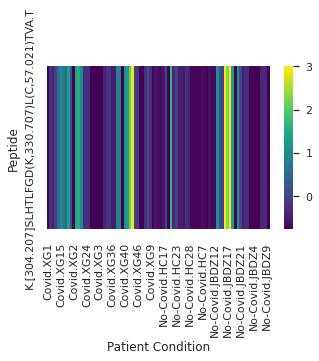

In [ ]:
heatmap(['K.[304.207]SLHTLFGD(K,330.707)L(C,57.021)TVA.T'], unmod_variants_processed, (5,3))

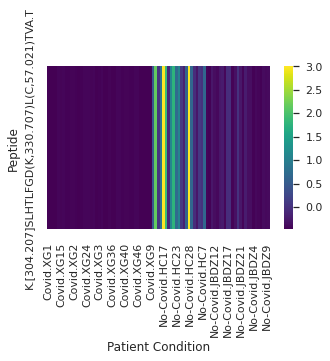

In [ ]:
heatmap(['K.[304.207]SLHTLFGD(K,330.707)L(C,57.021)TVA.T'], variants_processed, (5,3))

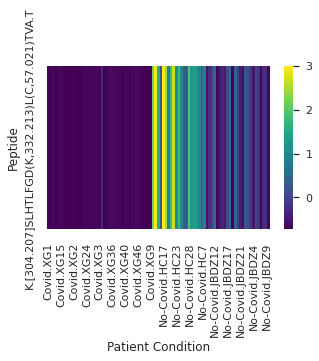

In [ ]:

heatmap(['K.[304.207]SLHTLFGD(K,332.213)L(C,57.021)TVA.T'], variants_processed, (5,3))

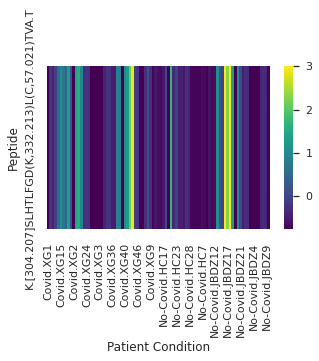

In [ ]:

heatmap(['K.[304.207]SLHTLFGD(K,332.213)L(C,57.021)TVA.T'], unmod_variants_processed, (5,3))

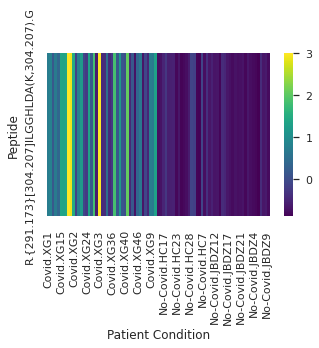

In [ ]:
heatmap(['R.{291.173}[304.207]ILGGHLDA(K,304.207).G'], variants_processed, (5,3))

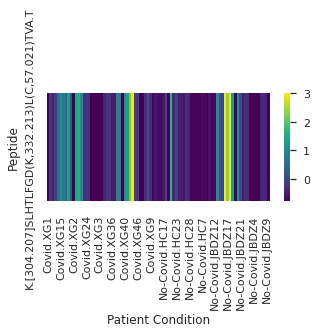

In [ ]:
heatmap(['K.[304.207]SLHTLFGD(K,332.213)L(C,57.021)TVA.T'], unmod_variants_processed, (5,2))

In [ ]:
get_p(['K.[304.207]SLHTLFGD(K,332.213)L(C,57.021)TVA.T'], unmod_variants_processed)

Wilcoxon Rank Sum test: 0.12988249029238105


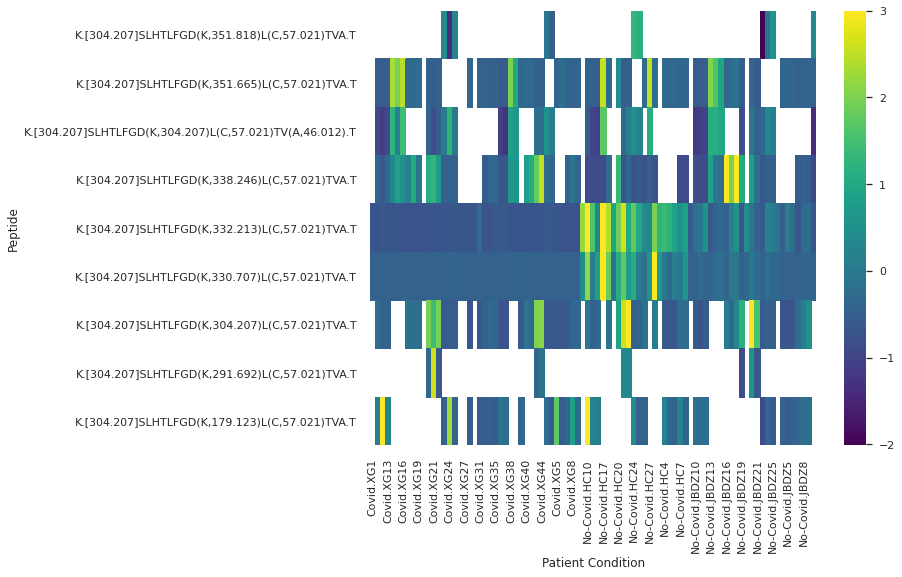

In [ ]:
heatmap(['K.[304.207]SLHTLFGD(K,351.818)L(C,57.021)TVA.T', 'K.[304.207]SLHTLFGD(K,351.665)L(C,57.021)TVA.T', 'K.[304.207]SLHTLFGD(K,304.207)L(C,57.021)TV(A,46.012).T','K.[304.207]SLHTLFGD(K,338.246)L(C,57.021)TVA.T', 'K.[304.207]SLHTLFGD(K,332.213)L(C,57.021)TVA.T','K.[304.207]SLHTLFGD(K,330.707)L(C,57.021)TVA.T', 'K.[304.207]SLHTLFGD(K,304.207)L(C,57.021)TVA.T', 'K.[304.207]SLHTLFGD(K,291.692)L(C,57.021)TVA.T', 'K.[304.207]SLHTLFGD(K,179.123)L(C,57.021)TVA.T'],variants_processed, (10,8))

In [ ]:
pvals = []
for p in ['K.[304.207]SLHTLFGD(K,351.665)L(C,57.021)TVA.T','K.[304.207]SLHTLFGD(K,338.246)L(C,57.021)TVA.T', 'K.[304.207]SLHTLFGD(K,330.707)L(C,57.021)TVA.T', 'K.[304.207]SLHTLFGD(K,304.207)L(C,57.021)TVA.T']:
  pvals.append(get_p(p, variants_processed))
print(pvals)

Wilcoxon Rank Sum test: 0.7558076384578489
Wilcoxon Rank Sum test: 0.04646454220531131
Wilcoxon Rank Sum test: 5.26945040729312e-11
Wilcoxon Rank Sum test: 0.421553275239673
[0.7558076384578489, 0.04646454220531131, 5.26945040729312e-11, 0.421553275239673]


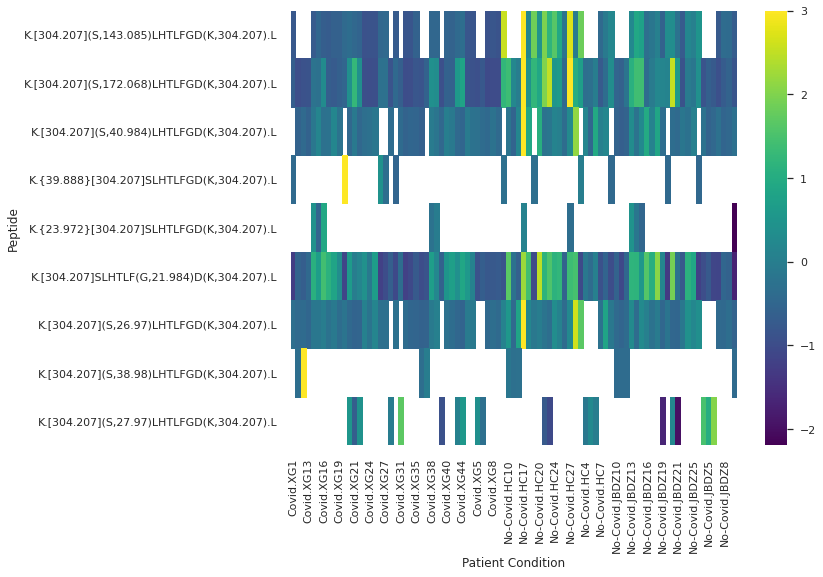

In [ ]:
heatmap(['K.[304.207](S,143.085)LHTLFGD(K,304.207).L','K.[304.207](S,172.068)LHTLFGD(K,304.207).L','K.[304.207](S,40.984)LHTLFGD(K,304.207).L','K.{39.888}[304.207]SLHTLFGD(K,304.207).L', 'K.{23.972}[304.207]SLHTLFGD(K,304.207).L','K.[304.207]SLHTLF(G,21.984)D(K,304.207).L','K.[304.207](S,26.97)LHTLFGD(K,304.207).L', 'K.[304.207](S,38.98)LHTLFGD(K,304.207).L','K.[304.207](S,27.97)LHTLFGD(K,304.207).L'],variants_processed,(10,8))

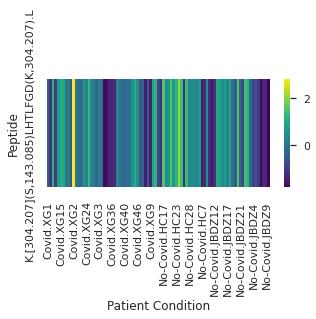

In [ ]:
heatmap(['K.[304.207](S,143.085)LHTLFGD(K,304.207).L'], unmod_variants_processed, (5,2))

In [ ]:
get_p('K.[304.207](S,143.085)LHTLFGD(K,304.207).L', unmod_variants_processed)

Wilcoxon Rank Sum test: 0.3941056012950265


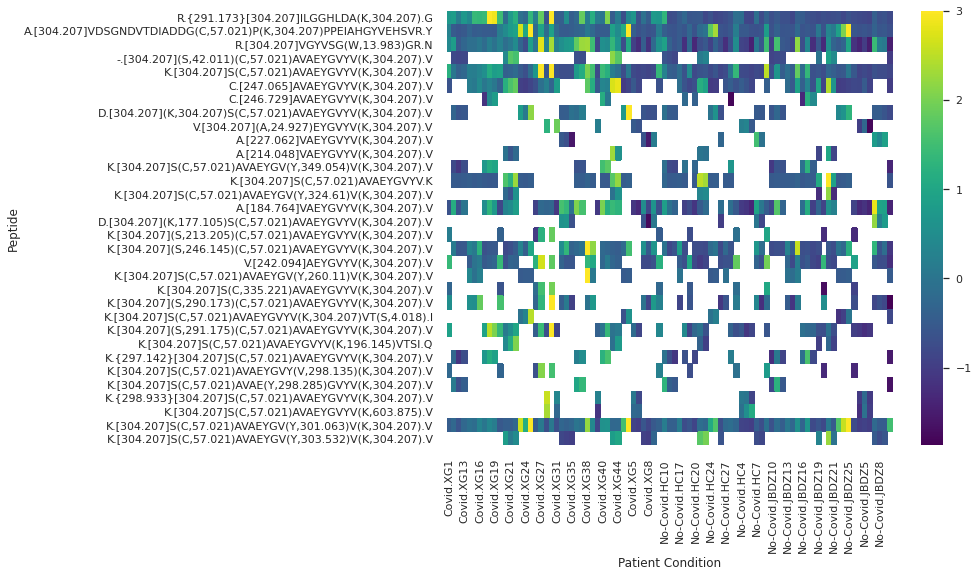

In [ ]:
#sp|P00738|HPT_HUMAN
top_2 = ['R.{291.173}[304.207]ILGGHLDA(K,304.207).G',
 'A.[304.207]VDSGNDVTDIADDG(C,57.021)P(K,304.207)PPEIAHGYVEHSVR.Y',
 'R.[304.207]VGYVSG(W,13.983)GR.N',
 '-.[304.207](S,42.011)(C,57.021)AVAEYGVYV(K,304.207).V',
 'K.[304.207]S(C,57.021)AVAEYGVYV(K,304.207).V',
 'C.[247.065]AVAEYGVYV(K,304.207).V',
 'C.[246.729]AVAEYGVYV(K,304.207).V',
 'D.[304.207](K,304.207)S(C,57.021)AVAEYGVYV(K,304.207).V',
 'V.[304.207](A,24.927)EYGVYV(K,304.207).V',
 'A.[227.062]VAEYGVYV(K,304.207).V',
 'A.[214.048]VAEYGVYV(K,304.207).V',
 'K.[304.207]S(C,57.021)AVAEYGV(Y,349.054)V(K,304.207).V',
 'K.[304.207]S(C,57.021)AVAEYGVYV.K',
 'K.[304.207]S(C,57.021)AVAEYGV(Y,324.61)V(K,304.207).V',
 'A.[184.764]VAEYGVYV(K,304.207).V',
 'D.[304.207](K,177.105)S(C,57.021)AVAEYGVYV(K,304.207).V',
 'K.[304.207](S,213.205)(C,57.021)AVAEYGVYV(K,304.207).V',
 'K.[304.207](S,246.145)(C,57.021)AVAEYGVYV(K,304.207).V',
 'V.[242.094]AEYGVYV(K,304.207).V',
 'K.[304.207]S(C,57.021)AVAEYGV(Y,260.11)V(K,304.207).V',
 'K.[304.207]S(C,335.221)AVAEYGVYV(K,304.207).V',
 'K.[304.207](S,290.173)(C,57.021)AVAEYGVYV(K,304.207).V',
 'K.[304.207]S(C,57.021)AVAEYGVYV(K,304.207)VT(S,4.018).I',
 'K.[304.207](S,291.175)(C,57.021)AVAEYGVYV(K,304.207).V',
 'K.[304.207]S(C,57.021)AVAEYGVYV(K,196.145)VTSI.Q',
 'K.{297.142}[304.207]S(C,57.021)AVAEYGVYV(K,304.207).V',
 'K.[304.207]S(C,57.021)AVAEYGVY(V,298.135)(K,304.207).V',
 'K.[304.207]S(C,57.021)AVAE(Y,298.285)GVYV(K,304.207).V',
 'K.{298.933}[304.207]S(C,57.021)AVAEYGVYV(K,304.207).V',
 'K.[304.207]S(C,57.021)AVAEYGVYV(K,603.875).V',
 'K.[304.207]S(C,57.021)AVAEYGV(Y,301.063)V(K,304.207).V',
 'K.[304.207]S(C,57.021)AVAEYGV(Y,303.532)V(K,304.207).V']
heatmap(top_2, variants_processed,(10,8))

Wilcoxon Rank Sum test: 1.4896652521460967e-11
Wilcoxon Rank Sum test: 0.0011166985098153602
Wilcoxon Rank Sum test: 5.464828475191292e-05
Wilcoxon Rank Sum test: 0.00418938046099078
Wilcoxon Rank Sum test: 0.018282163486860945
Wilcoxon Rank Sum test: 0.9803772510341292
Wilcoxon Rank Sum test: 0.02907514163664436
Wilcoxon Rank Sum test: 0.0029233579826115834
Wilcoxon Rank Sum test: 0.002173582921983565
Wilcoxon Rank Sum test: 9.932883518050992e-05
Wilcoxon Rank Sum test: 0.11429319453394263


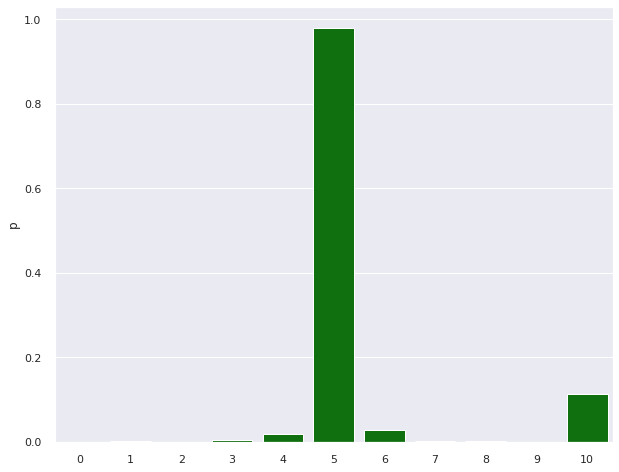

In [ ]:
plot_histogram_p(remove_nas(top_2,variants_processed), variants_processed)

Wilcoxon Rank Sum test: 1.4896652521460967e-11


1.4896652521460967e-11

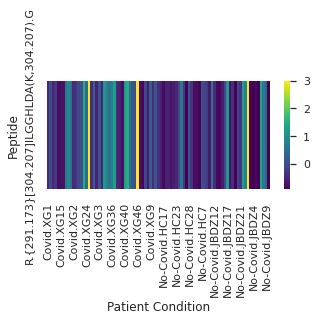

In [ ]:
heatmap(['R.{291.173}[304.207]ILGGHLDA(K,304.207).G'], unmod_variants_processed,(5,2))
get_p('R.{291.173}[304.207]ILGGHLDA(K,304.207).G', variants_processed)

In [ ]:
file_ = "/content/drive/MyDrive/top4.tsv"
variants_ = pd.read_csv(file_, sep="\t", low_memory=False)

Number < 0.05:  3 Total Number:  19 Percent:  0.15789473684210525


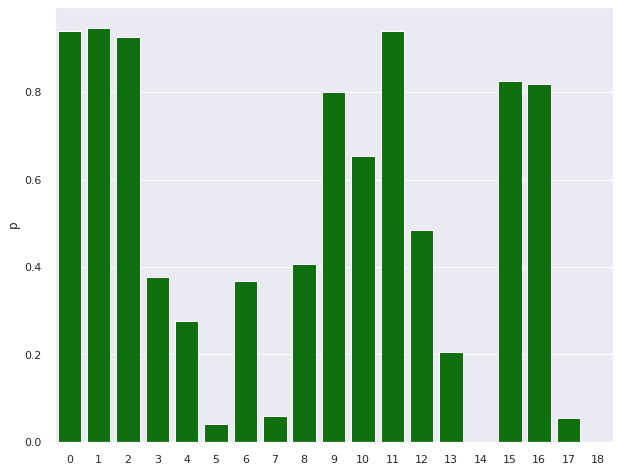

In [ ]:
top_4 = list(variants_['Peptide'])
plot_histogram_p(remove_nas(top_4,variants_processed), variants_processed)

Number < 0.05:  5 Total Number:  32 Percent:  0.15625


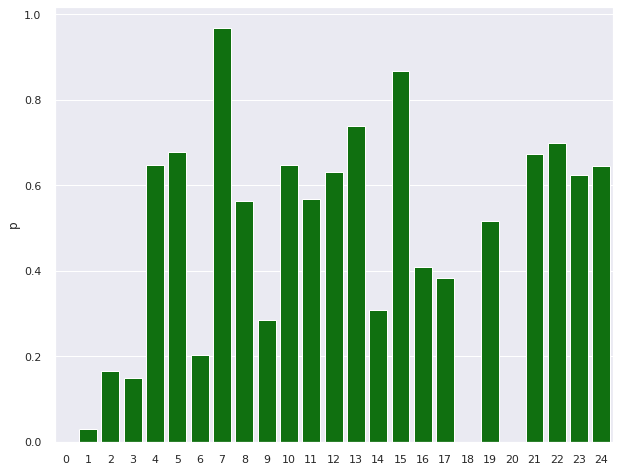

In [ ]:
top_3 = list(variants_['Peptide'])
plot_histogram_p(remove_nas(top_3,variants_processed), variants_processed)

Number < 0.05:  415 Total Number:  935 Percent:  0.44385026737967914


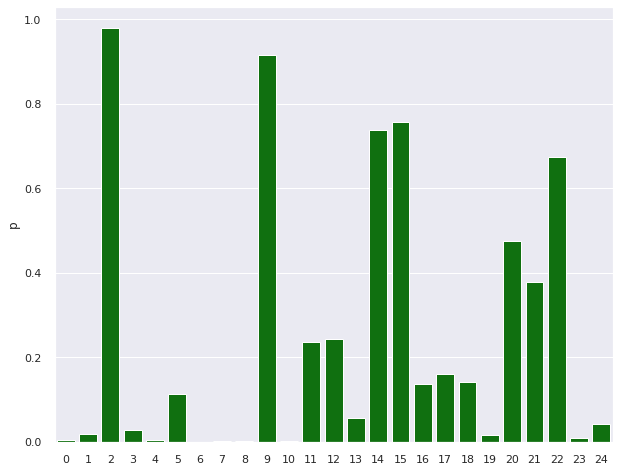

In [ ]:
top_2 = list(variants_['Peptide'])
plot_histogram_p(remove_nas(top_2,variants_processed), variants_processed)
#44%

In [ ]:
def plot_histogram_p( peptides, df):
  peptides_new = remove_nas(peptides,df)
  p = {'p':[]}
  for peptide in peptides_new:
    p['p'].append(get_p(peptide, df))
  
  count=0
  for i in p['p']:
    if(i<0.05):
      count+=1
  if(len(p['p']) == 0):
    return 0
  return count/len(peptides)
  #newdf = pd.DataFrame(data=p)
  #his_data = sns.barplot(x=newdf.index , y='p' ,data=newdf,color='green')

Wilcoxon Rank Sum test: 0.9686923502465328
Wilcoxon Rank Sum test: 0.5692871127533822
Wilcoxon Rank Sum test: 0.6758512510550434
Wilcoxon Rank Sum test: 0.5674985740709135
Wilcoxon Rank Sum test: 0.3132462129533462
Wilcoxon Rank Sum test: 0.6515834070637296
Wilcoxon Rank Sum test: 0.8311704095417624
Wilcoxon Rank Sum test: 0.6159684113145973
Wilcoxon Rank Sum test: 0.45984145958176403
Wilcoxon Rank Sum test: 0.8033849019769658
Wilcoxon Rank Sum test: 0.38079711215591416
Wilcoxon Rank Sum test: 0.979527957644263
Wilcoxon Rank Sum test: 0.6423133875057312
Wilcoxon Rank Sum test: 0.9266730379320675
Wilcoxon Rank Sum test: 0.800838179706995
Wilcoxon Rank Sum test: 0.5552152388861679
Wilcoxon Rank Sum test: 0.6597678633269399
Wilcoxon Rank Sum test: 0.8752499099109733


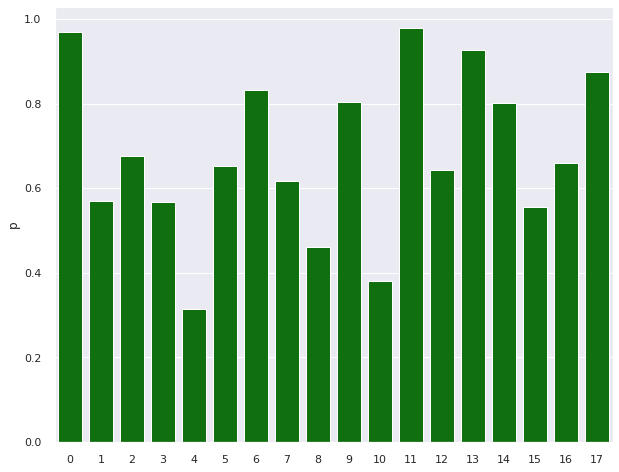

In [ ]:
#sp|P02768|ALBU_HUMAN
top_3 = ['T.[304.207](C,57.021)FAEEG(K,304.207)(K,304.207).L', 'T.[304.207](C,-35.104)FAEEG(K,304.207)(K,304.207).L', 
         '-.RP(C,57.021)FSALEVDETYVPKEFNAE.-', '-.EFNAETFTFHADI(C,57.021)TLSEK.-', '-.FSALEVDETYVPK.-', '-.AV(M,15.995)DDFAAFVEK.-',
         '-.AVMDDFAAFVEK.-', '-.RP(C,57.021)FSALEVDETYVPK.-', '-.KQTALVELVK.-', '-.QTALVELVK.-', '-.[-17.027]QTALVELVK.-',
         '-.(C,57.021)(C,57.021)TESLVNR.-', '-.EFNAETFTFHADI(C,57.021)TLSEKER.-', '-.(M,15.995)P(C,57.021)AEDYLSVVLNQL(C,57.021)VLHEK.-',
         '-.MP(C,57.021)AEDYLSVVLNQL(C,57.021)VLHEK.-', '-.[304.207](R,43.006)MP(C,57.021)AEDYLSVVLNQL(C,57.021)VLHE(K,304.207).T',
         'N.[304.207]AETFTFHADI(C,57.021)TLSE(K,304.207).E', 'K.[304.207]R(M,15.995)P(C,57.021)AEDYLSVVLNQL(C,57.021)VLHE(K,304.207).T',
         'K.[304.207]RMP(C,57.021)AEDYLSVVLN(Q,0.984)L(C,57.021)VLHE(K,304.207).T',
         '-.[304.207](M,42.011)P(C,57.021)AEDYLSVVLNQL(C,57.021)VLHE(K,304.207).T',
         '-.[304.207](E,43.006)A(K,304.207)RMP(C,57.021)AEDYLSVVLNQL(C,57.021)VLHE(K,304.207).T',
         'K.[304.207]EF(N,0.984)AETFTFHADI(C,57.021)TLSE(K,304.207)ER.Q',
         'K.[304.207]EFNAETFTFHADI(C,57.021)TLSE(K,304.207)ER.Q',
         'R.[304.207]MP(C,57.021)AEDYLSVVL(N,0.984)QL(C,57.021)VLHE(K,304.207).T',
         'P.[304.207](C,57.021)AEDYLSVVLNQL(C,57.021)VLHE(K,304.207).T',
         'F.[304.207]NAETFTFHADI(C,57.021)TLSE(K,304.207)ER.Q',
         'L.[304.207]SVVLNQL(C,57.021)VLHE(K,304.207).T',
         'R.[304.207]VT(K,304.207)(C,57.021)(C,57.021)TESLVNR.R',
         'N.[304.207]AETFTFHADI(C,57.021)TLSE(K,304.207)ER.Q',
         'F.[304.207]TFHADI(C,57.021)TLSE(K,304.207).E']

plot_histogram_p(remove_nas(top_3,variants_processed), variants_processed)

In [ ]:
def remove_nas(peptides, df):
  final = []
  for peptide in peptides:
    df[peptide].replace(0.0, np.nan, inplace=True)
    if(df[peptide].isna().sum() < 45):
      final.append(peptide)
  return final

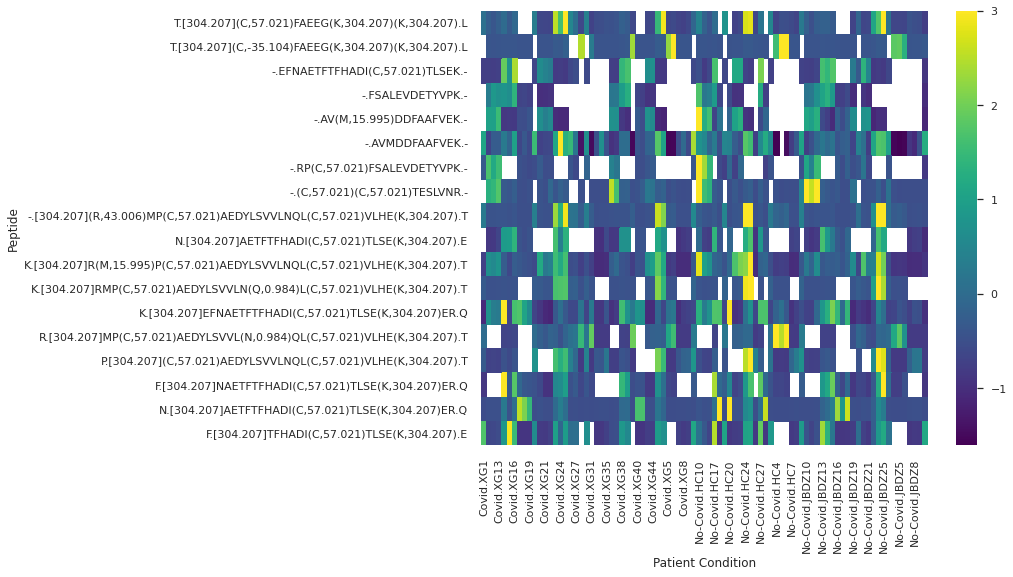

In [ ]:
f = remove_nas(top_3, variants_processed)
heatmap(f, variants_processed, (10,8))

In [ ]:
t = []
for peptide in f:
  t.append(get_p(peptide,variants_processed))
t

Wilcoxon Rank Sum test: 0.9686923502465328
Wilcoxon Rank Sum test: 0.5692871127533822
Wilcoxon Rank Sum test: 0.6758512510550434
Wilcoxon Rank Sum test: 0.5674985740709135
Wilcoxon Rank Sum test: 0.3132462129533462
Wilcoxon Rank Sum test: 0.6515834070637296
Wilcoxon Rank Sum test: 0.8311704095417624
Wilcoxon Rank Sum test: 0.6159684113145973
Wilcoxon Rank Sum test: 0.45984145958176403
Wilcoxon Rank Sum test: 0.8033849019769658
Wilcoxon Rank Sum test: 0.38079711215591416
Wilcoxon Rank Sum test: 0.979527957644263
Wilcoxon Rank Sum test: 0.6423133875057312
Wilcoxon Rank Sum test: 0.9266730379320675
Wilcoxon Rank Sum test: 0.800838179706995
Wilcoxon Rank Sum test: 0.5552152388861679
Wilcoxon Rank Sum test: 0.6597678633269399
Wilcoxon Rank Sum test: 0.8752499099109733


[0.9686923502465328,
 0.5692871127533822,
 0.6758512510550434,
 0.5674985740709135,
 0.3132462129533462,
 0.6515834070637296,
 0.8311704095417624,
 0.6159684113145973,
 0.45984145958176403,
 0.8033849019769658,
 0.38079711215591416,
 0.979527957644263,
 0.6423133875057312,
 0.9266730379320675,
 0.800838179706995,
 0.5552152388861679,
 0.6597678633269399,
 0.8752499099109733]

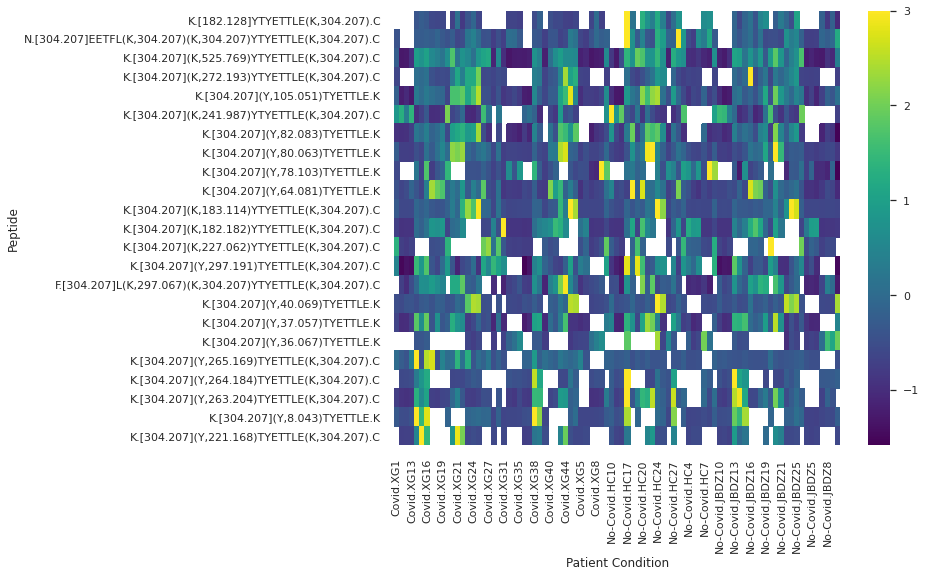

In [ ]:
#tr|A0A087WWT3|A0A087WWT3_HUMAN
top_4 = ['K.[304.207](Y,-91.643)TYETTLE(K,304.207).C', 'K.[304.207](Y,-92.143)TYETTLE(K,304.207).C', 'K.[185.590]YTYETTLE(K,304.207).C', 
         'K.[184.792]YTYETTLE(K,304.207).C', 'K.[182.128]YTYETTLE(K,304.207).C', 'K.[181.608]YTYETTLE(K,304.207).C', 
         'K.[180.172]YTYETTLE(K,304.207).C', 'N.[304.207]EETFL(K,304.207)(K,304.207)YTYETTLE(K,304.207).C',
         'K.[304.207](K,525.769)YTYETTLE(K,304.207).C', 'K.[304.207](K,304.207)YTYETTLE(K,304.207).C',
         'K.[304.207](K,287.002)YTYETTLE(K,304.207).C', 'K.[304.207](K,272.193)YTYETTLE(K,304.207).C',
         'K.[304.207](K,264.591)YTYETTLE(K,304.207).C', 'K.[304.207](Y,108.105)TYETTLE.K',
         'K.[304.207](Y,105.051)TYETTLE.K', 'K.[304.207](K,241.987)YTYETTLE(K,304.207).C',
         'K.[304.207](Y,82.083)TYETTLE.K', 'K.[304.207](Y,80.971)TYETTLE.K', 'K.[304.207](Y,80.063)TYETTLE.K',
         'K.[304.207](Y,79.985)TYETTLE.K', 'K.[304.207](Y,79.323)TYETTLE.K', 'K.[304.207](K,218.052)YTYETTLE(K,304.207).C',
         'K.[304.207](Y,78.103)TYETTLE.K', 'K.[304.207](Y,77.397)TYETTLE.K', 'K.[304.207](K,216.931)YTYETTLE(K,304.207).C',
         'K.[304.207](K,216.463)YTYETTLE(K,304.207).C', 'K.[304.207](Y,64.081)TYETTLE.K', 'K.[304.207](K,194.08)YTYETTLE(K,304.207).C',
         'K.[304.207](K,183.114)YTYETTLE(K,304.207).C','K.[304.207](K,182.182)YTYETTLE(K,304.207).C', 'K.[304.207](K,181.996)YTYETTLE(K,304.207).C',
         'K.[304.207](K,227.062)YTYETTLE(K,304.207).C', 'K.[304.207](K,226.051)YTYETTLE(K,304.207).C', 'K.[304.207](K,177.934)YTYETTLE(K,304.207).C',
         'K.[304.207](K,176.035)YTYETTLE(K,304.207).C', 'K.[304.207](Y,297.191)TYETTLE(K,304.207).C', 
         'K.[304.207](Y,44.139)TYETTLE.K', 'F.[304.207]L(K,304.207)(K,304.207)YTYETTLE(K,304.207).C', 
         'F.[304.207]L(K,297.067)(K,304.207)YTYETTLE(K,304.207).C', 'K.[304.207](Y,40.069)TYETTLE.K', 
         'K.[304.207](Y,38.059)TYETTLE.K', 'K.[304.207](Y,37.057)TYETTLE.K', 'K.[304.207](Y,36.067)TYETTLE.K',
         'K.[304.207](Y,269.183)TYETTLE(K,304.207).C', 'K.[304.207](Y,267.188)TYETTLE(K,304.207).C',
         'K.[304.207](Y,265.169)TYETTLE(K,304.207).C', 'K.[304.207](Y,264.184)TYETTLE(K,304.207).C',
         'K.[304.207](Y,263.204)TYETTLE(K,304.207).C', 'K.[304.207](Y,261.995)TYETTLE(K,304.207).C',
         'K.[304.207](Y,21.169)TYETTLE.K', 'K.[304.207](Y,21.007)TYETTLE.K', 'K.[304.207](Y,259.171)TYETTLE(K,304.207).C',
         'K.[304.207](Y,253.184)TYETTLE(K,304.207).C', 'K.[304.207](Y,251.192)TYETTLE(K,304.207).C', 
         'K.[304.207](Y,250.19)TYETTLE(K,304.207).C', 'K.[304.207](Y,8.043)TYETTLE.K','K.[304.207](Y,6.043)TYETTLE.K',
         'K.[304.207](Y,221.168)TYETTLE(K,304.207).C', 'L.[304.207](K,304.207)(K,304.207)YTYETTLE(K,304.207).C']

f1 = remove_nas(top_4, variants_processed)
heatmap(f1, variants_processed,(10,8))

In [ ]:
ap = [i for i in f1 if get_p(i, variants_processed)<0.05]
ap

Wilcoxon Rank Sum test: 6.590527541212721e-05
Wilcoxon Rank Sum test: 0.030876423142632024
Wilcoxon Rank Sum test: 0.16595387040296228
Wilcoxon Rank Sum test: 0.1488719934075194
Wilcoxon Rank Sum test: 0.6481102369719635
Wilcoxon Rank Sum test: 0.6787059899450518
Wilcoxon Rank Sum test: 0.9686923502465328
Wilcoxon Rank Sum test: 0.5635650771508343
Wilcoxon Rank Sum test: 0.2850189997281425
Wilcoxon Rank Sum test: 0.6481102369719635
Wilcoxon Rank Sum test: 0.56903274313502
Wilcoxon Rank Sum test: 0.6299993525714083
Wilcoxon Rank Sum test: 0.2022840577475742
Wilcoxon Rank Sum test: 0.7374596180807848
Wilcoxon Rank Sum test: 0.3075111789565621
Wilcoxon Rank Sum test: 0.86752295255783
Wilcoxon Rank Sum test: 0.40906495960122924
Wilcoxon Rank Sum test: 0.3829149776342603
Wilcoxon Rank Sum test: 1.5339718174165652e-07
Wilcoxon Rank Sum test: 0.5171833335107219
Wilcoxon Rank Sum test: 0.0006523401580530963
Wilcoxon Rank Sum test: 0.6741658909452324
Wilcoxon Rank Sum test: 0.6999881039458067


['K.[182.128]YTYETTLE(K,304.207).C',
 'N.[304.207]EETFL(K,304.207)(K,304.207)YTYETTLE(K,304.207).C',
 'K.[304.207](Y,265.169)TYETTLE(K,304.207).C',
 'K.[304.207](Y,263.204)TYETTLE(K,304.207).C']

Wilcoxon Rank Sum test: 6.590527541212721e-05
Wilcoxon Rank Sum test: 0.030876423142632024
Wilcoxon Rank Sum test: 0.16595387040296228
Wilcoxon Rank Sum test: 0.1488719934075194
Wilcoxon Rank Sum test: 0.6481102369719635
Wilcoxon Rank Sum test: 0.6787059899450518
Wilcoxon Rank Sum test: 0.9686923502465328
Wilcoxon Rank Sum test: 0.5635650771508343
Wilcoxon Rank Sum test: 0.2850189997281425
Wilcoxon Rank Sum test: 0.6481102369719635
Wilcoxon Rank Sum test: 0.56903274313502
Wilcoxon Rank Sum test: 0.6299993525714083
Wilcoxon Rank Sum test: 0.2022840577475742
Wilcoxon Rank Sum test: 0.7374596180807848
Wilcoxon Rank Sum test: 0.3075111789565621
Wilcoxon Rank Sum test: 0.86752295255783
Wilcoxon Rank Sum test: 0.40906495960122924
Wilcoxon Rank Sum test: 0.3829149776342603
Wilcoxon Rank Sum test: 1.5339718174165652e-07
Wilcoxon Rank Sum test: 0.5171833335107219
Wilcoxon Rank Sum test: 0.0006523401580530963
Wilcoxon Rank Sum test: 0.6741658909452324
Wilcoxon Rank Sum test: 0.6999881039458067


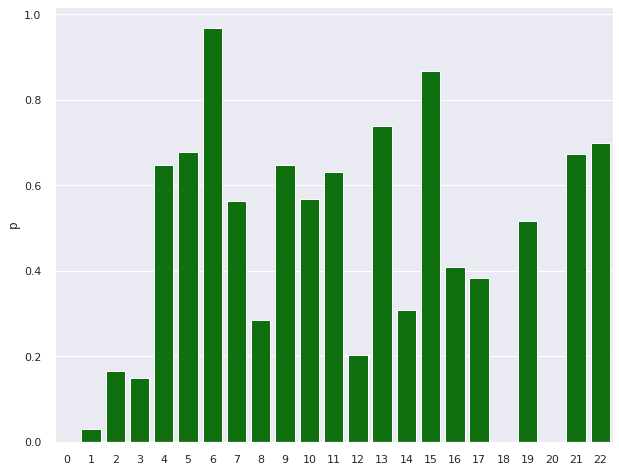

In [ ]:
plot_histogram_p(f1, variants_processed)

In [ ]:
def find_top(whole_df,df):
  from tqdm import tqdm
  proteins_list = list(whole_df['Top_protein'].unique())
  vals = {}
  for protein in tqdm(proteins_list,position=0, leave=True):
    if(protein == np.nan):
      continue
    peptides = list(whole_df.loc[whole_df['Top_protein'] == protein]['Peptide'])
    vals[protein] = plot_histogram_p(remove_nas(peptides,df), df)
    #print(protein, ": ",plot_histogram_p(peptides, df))
  return vals


In [ ]:
tops = find_top(variants, variants_processed)

100%|██████████| 402/402 [02:01<00:00,  3.32it/s]


In [ ]:
s = sorted(tops, key=lambda k: tops[k], reverse=True)
s

['sp|P14618|KPYM_HUMAN',
 'tr|A0A0G2JL69|A0A0G2JL69_HUMAN',
 'sp|P21333|FLNA_HUMAN',
 'tr|J3QLC9|J3QLC9_HUMAN',
 'sp|P00738|HPT_HUMAN',
 'sp|Q15485|FCN2_HUMAN',
 'sp|P02743|SAMP_HUMAN',
 'sp|Q14766|LTBP1_HUMAN',
 'sp|Q14520|HABP2_HUMAN',
 'sp|P08253|MMP2_HUMAN',
 'sp|P08582|TRFM_HUMAN',
 'sp|Q92820|GGH_HUMAN',
 'sp|Q9UGM5|FETUB_HUMAN',
 'sp|P00739|HPTR_HUMAN',
 'sp|P51884|LUM_HUMAN',
 'sp|P02768-3|ALBU_HUMAN',
 'sp|P02768-2|ALBU_HUMAN',
 'sp|P02748|CO9_HUMAN',
 'sp|O00533|NCHL1_HUMAN',
 'tr|A0A0C4DGB6|A0A0C4DGB6_HUMAN',
 'tr|A0A087WWT3|A0A087WWT3_HUMAN',
 'sp|P05543|THBG_HUMAN',
 'sp|Q9UHG3|PCYOX_HUMAN',
 'sp|P54108|CRIS3_HUMAN',
 'tr|H0YA55|H0YA55_HUMAN',
 'sp|P12259|FA5_HUMAN',
 'sp|P04070|PROC_HUMAN',
 'sp|P00746|CFAD_HUMAN',
 'sp|P13671|CO6_HUMAN',
 'sp|O75636|FCN3_HUMAN',
 'sp|P04003|C4BPA_HUMAN',
 'sp|P06727|APOA4_HUMAN',
 'sp|P07225|PROS_HUMAN',
 'sp|Q9BXR6|FHR5_HUMAN',
 'tr|A0A0G2JSC0|A0A0G2JSC0_HUMAN',
 'sp|P02671|FIBA_HUMAN',
 'sp|P02763|A1AG1_HUMAN',
 'tr|D6RHD5|D6RHD5_HUMAN

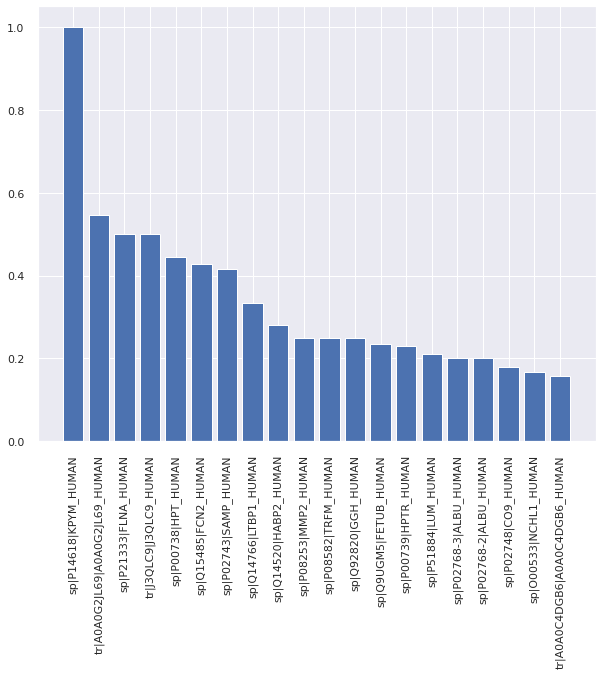

In [ ]:
import matplotlib.pyplot as plt

names = sorted(tops, key=lambda k: tops[k], reverse=True)[:20]
values = [tops[i] for i in names]

plt.bar(range(20), values)
plt.xticks(range(20),names, rotation='vertical')
plt.show()
#his_data = sns.barplot(x=tops.keys , y= ,data=newdf,color='green')

In [ ]:
def find_top2(whole_df,df):
  from tqdm import tqdm
  proteins_list = list(whole_df['Top_protein'].unique())
  vals = {}
  for protein in tqdm(proteins_list,position=0, leave=True):
    if(protein == np.nan):
      continue
    peptides = list(whole_df.loc[whole_df['Top_protein'] == protein]['Peptide'])
    vals[protein] = plot_histogram_p(peptides, df)
    #print(protein, ": ",plot_histogram_p(peptides, df))
  return vals
tops2 = find_top2(variants, variants_processed)

100%|██████████| 402/402 [01:13<00:00,  5.46it/s]


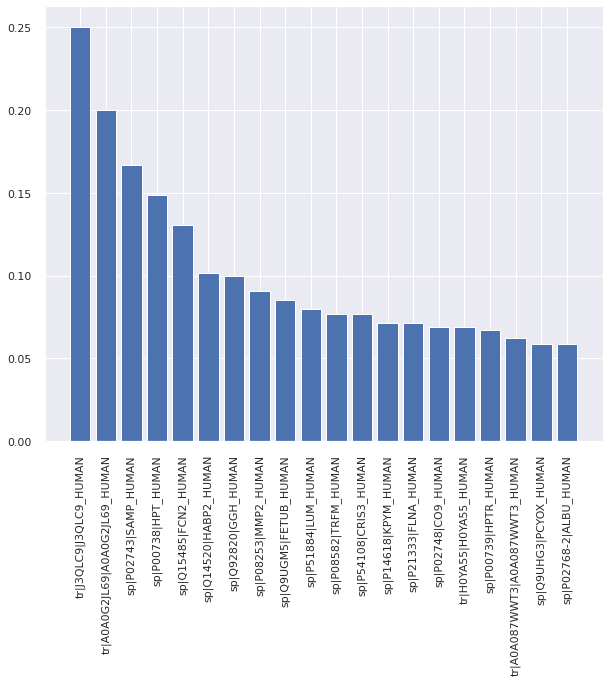

In [ ]:
import matplotlib.pyplot as plt

names = sorted(tops2, key=lambda k: tops2[k], reverse=True)[:20]
values = [tops2[i] for i in names]

plt.bar(range(20), values)
plt.xticks(range(20),names, rotation='vertical')
plt.show()
#his_data = sns.barplot(x=tops.keys , y= ,data=newdf,color='green')

In [ ]:
peptides = list(variants.loc[variants['Top_protein'] == 'sp|P14618|KPYM_HUMAN']['Peptide'])


In [ ]:
print(len(peptides))
for p in peptides:  
  print(variants_processed[p].isna().sum())
  #print(90-variants_processed[p].isna().sum())

14
55
79
79
79
55
33
78
55
56
78
79
79
79
77


In [ ]:
peptides = list(variants.loc[variants['Top_protein'] == 'sp|P02743|SAMP_HUMAN']['Peptide'])

print(len(peptides))
for p in peptides:  
  print(variants_processed[p].isna().sum())
  #print(90-variants_processed[p].isna().sum())

60
12
0
77
79
56
66
43
11
0
78
78
66
66
66
78
79
56
77
21
66
78
11
55
55
78
65
79
21
0
45
79
67
77
33
35
44
0
79
11
77
31
77
32
78
44
67
66
10
5
79
79
77
10
35
77
77
34
35
44
66


In [ ]:
def other_peptides(w_df, q_peptides, sequence):
  peptides = list(w_df.loc[w_df['Unmodified_sequence']==sequence]['Peptide'])
  p = [pt for pt in peptides if(pt not in q_peptides)]
  return p


In [ ]:
f = other_peptides(variants, ['K.[304.207]SLHTLFGD(K,332.213)L(C,57.021)TVA.T', 'K.[304.207]SLHTLFGD(K,330.707)L(C,57.021)TVA.T'],'.SLHTLFGDKLCTVA.')

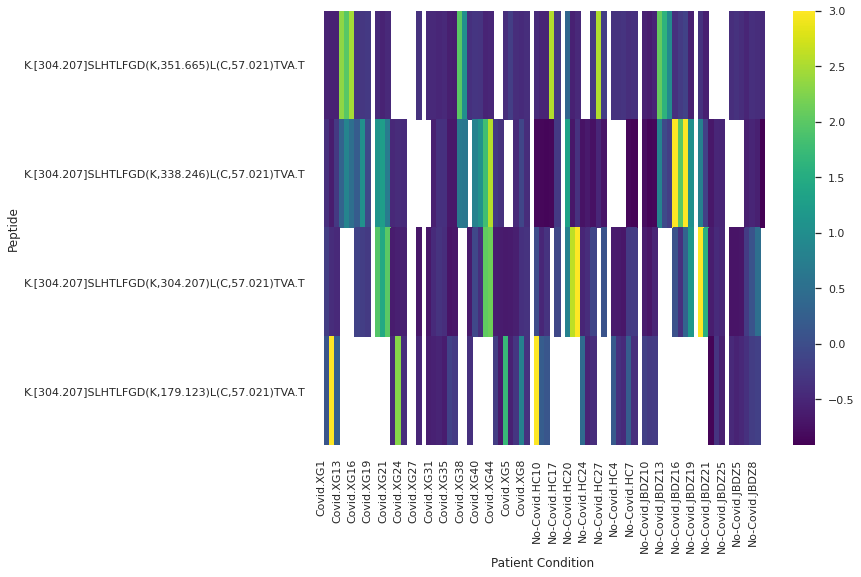

In [ ]:
heatmap(remove_nas(f,variants_processed), variants_processed, (10,8))

In [ ]:
plot_histogram_p(remove_nas(f,variants_processed), variants_processed)

0.25

In [ ]:
f = other_peptides(variants, ['R.{291.173}[304.207]ILGGHLDA(K,304.207).G', 'A.[304.207]VDSGNDVTDIADDG(C,57.021)P(K,304.207)PPEIAHGYVEHSVR.Y', 'R.[304.207]VGYVSG(W,13.983)GR.N'],'.ILGGHLDAK.')

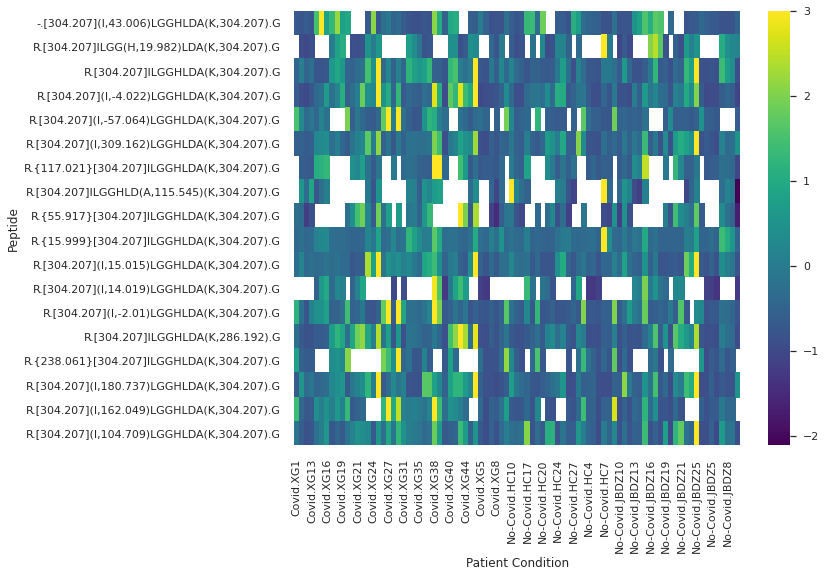

In [ ]:
heatmap(remove_nas(f,variants_processed), variants_processed, (10,8))

In [ ]:
plot_histogram_p(remove_nas(f,variants_processed), variants_processed)

0.3888888888888889

In [ ]:
1-0.3888888888888889


0.6111111111111112

In [ ]:
f = list(variants.loc[variants['Top_protein'] == 'sp|P00738|HPT_HUMAN']['Peptide'])
plot_histogram_p(remove_nas(f,variants_processed), variants_processed)

0.44385026737967914

In [ ]:
len(f)

2787

In [ ]:
vals = {}
count = 0
for i in f:
  p = get_p(i,variants_processed) 
  vals[i] = p
  if(p<0.05):
    count+=1
print(count)


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:6475: RuntimeWarning: invalid value encountered in double_scalars
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


850


In [ ]:
len(f)-850

1937

In [ ]:
top_p = sorted(vals, key=lambda k: vals[k],reverse=True)[:10]

In [ ]:
least_p = sorted(vals, key=lambda k: vals[k])[:10]

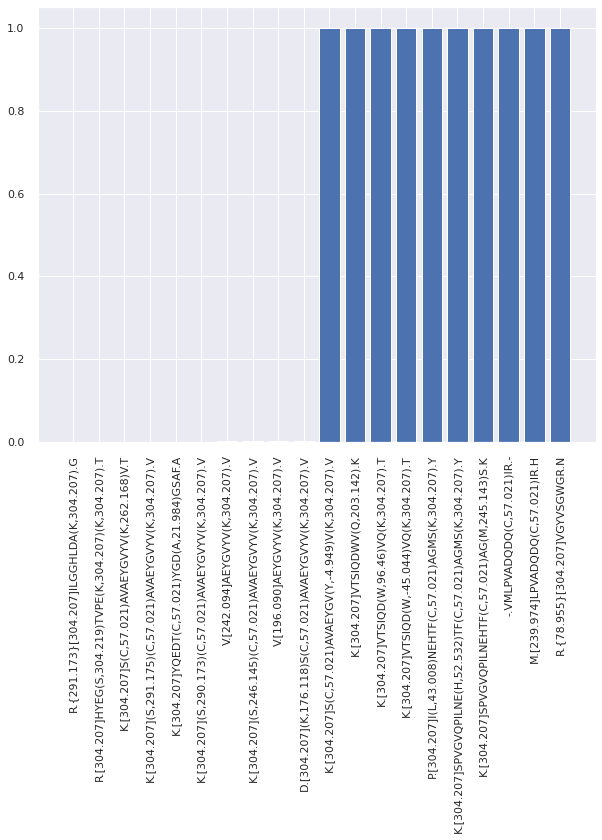

In [ ]:
import matplotlib.pyplot as plt

names = least_p+top_p
values = [get_p(i,variants_processed) for i in names]

plt.bar(range(len(names)), values)
plt.xticks(range(len(names)),names, rotation='vertical')
plt.show()
#his_data = sns.barplot(x=tops.keys , y= ,data=newdf,color='green')

R.{291.173}[304.207]ILGGHLDA(K,304.207).G


NameError: ignored

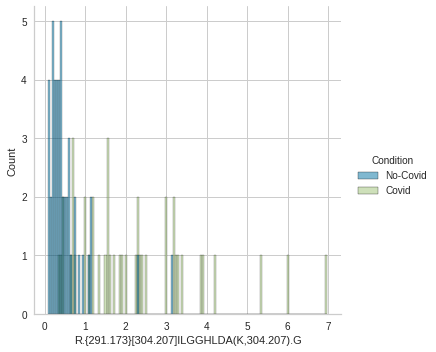

In [ ]:
print_histogram_and_stat_test(['R.{291.173}[304.207]ILGGHLDA(K,304.207).G'], variants_processed)

In [ ]:
print